In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
from dateutil.relativedelta import relativedelta
import datetime
import statsmodels.api as sm
from scipy.optimize import brute
from itertools import product

import warnings



# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [2]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')

In [3]:
air_stores = list(air_store_info['air_store_id'])
test = air_visit_data[air_visit_data['air_store_id']==air_stores[0]]
test.index = pd.DatetimeIndex(test['visit_date'])
display(test.head())

air_store_id  visit_date  visitors
visit_date                                            
2016-07-01  air_0f0cdeee6c9bf3d7  2016-07-01        18
2016-07-02  air_0f0cdeee6c9bf3d7  2016-07-02        37
2016-07-03  air_0f0cdeee6c9bf3d7  2016-07-03        20
2016-07-04  air_0f0cdeee6c9bf3d7  2016-07-04        16
2016-07-05  air_0f0cdeee6c9bf3d7  2016-07-05        15

In [4]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [5]:
from math import sqrt

In [6]:
def rms(actual_series, prediction_series):
    return mean_squared_error(actual_series, prediction_series)

The RMSLE is calculated as


where:

nn is the total number of observations 
pipi is your prediction of visitors
aiai is the actual number of visitors 
log(x)log⁡(x) is the natural logarithm of x

In [7]:
def rmsle(actual_series, prediction_series):
    return sqrt(mean_squared_log_error(actual_series, prediction_series))

In [9]:
data_col = 'visitors'

def build_model(iter_param, series, params_list, static_param=None):
  if static_param==None:
    ords = iter_param
    sords = (1,0,0,0)
  else:
    ords = static_param
    sords = iter_param
  try:
    mod = sm.tsa.statespace.SARIMAX(
        series, trend='n', order=ords, seasonal_order=sords
      )
    res = mod.fit(disp=0)
    params_list.append(tuple((ords, sords, res.aic, rms(series,res.predict()), rmsle(series,res.predict()))))
    print(params_list[-1])
  except:
    pass

'''m = []
res = build_model((1,0,0), test[data_col], m)
print('AIC: %s' % res.aic)
begin = len(test)-1
end = (datetime.datetime(2017,5,30).date()-test.index[-1].date()).days+len(test)
#res.predict(start=begin, end=end, dynamic=True)'''

"m = []\nres = build_model((1,0,0), test[data_col], m)\nprint('AIC: %s' % res.aic)\nbegin = len(test)-1\nend = (datetime.datetime(2017,5,30).date()-test.index[-1].date()).days+len(test)\n#res.predict(start=begin, end=end, dynamic=True)"

In [10]:
def parameter_search2(series, num_models, grid_diameter=3):
  models = []
  param_vals = range(grid_diameter)
  grid = list(product(param_vals,param_vals,param_vals))
  for ord_param in grid:
    for sord_param in [(p[0],p[1],p[2],7) for p in grid]:
      build_model(sord_param, series, models, ord_param)
  return sorted(models, key=lambda x: x[2])[:num_models], models

## Build some models and optimize the parameters

This runs parameter search loop with a specified diameter and outputs a list of models by `ord_params`, `sord_params`, `aic`, `rms`, `rmsle` for sorting purposes later.

In [57]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
rerun = False
if rerun:
    mods = parameter_search2(test['visitors'], 5, 4)

In [35]:
mods

([((3, 1, 1),
   (0, 1, 2, 7),
   2075.0165798640974,
   160.86600699142213,
   0.5834925932577663),
  ((3, 1, 1),
   (1, 1, 2, 7),
   2075.3788406395188,
   159.52128652190868,
   0.5795586735210209),
  ((3, 1, 1),
   (2, 1, 1, 7),
   2075.978850501835,
   159.80699552411866,
   0.5810161328227316),
  ((3, 1, 1),
   (1, 1, 1, 7),
   2076.2371367155215,
   161.58757636465398,
   0.585383017429033),
  ((3, 1, 1),
   (2, 1, 2, 7),
   2077.4814335286719,
   159.51306080467691,
   0.5794245987938618)],
 [((0, 0, 0),
   (0, 1, 1, 7),
   2110.7558857864665,
   194.87665402412671,
   0.7681946428159536),
  ((0, 0, 0),
   (0, 1, 2, 7),
   2088.5417086049065,
   179.22066831696822,
   0.74419176868529),
  ((0, 0, 0),
   (0, 1, 3, 7),
   2089.8817626425762,
   179.09422975013933,
   0.7450684643108101),
  ((0, 0, 0),
   (1, 0, 0, 7),
   2223.7224609403997,
   239.20072770336463,
   0.8581854778597816),
  ((0, 0, 0),
   (1, 0, 1, 7),
   2178.5860467302655,
   197.13271546816333,
   0.768902559223

### Output the best with respect to each metric:

In [324]:
print('aic\n', [(i[0],i[1],i[2]) for i in sorted(mods[1], key=lambda x: x[2])[:5]])
print('rms\n', [(i[0],i[1],i[3]) for i in sorted(mods[1], key=lambda x: x[3])[:5]])
print('rmsle\n', [(i[0],i[1],i[4]) for i in sorted(mods[1], key=lambda x: x[4])[:5]])

aic
 [((3, 1, 1), (0, 1, 2, 7), 2075.0165798640974), ((3, 1, 1), (1, 1, 2, 7), 2075.3788406395188), ((3, 1, 1), (2, 1, 1, 7), 2075.978850501835), ((3, 1, 1), (1, 1, 1, 7), 2076.2371367155215), ((3, 1, 1), (2, 1, 2, 7), 2077.4814335286719)]
rms
 [((3, 1, 1), (2, 0, 3, 7), 150.96023993399709), ((3, 1, 1), (3, 0, 3, 7), 152.98023356833002), ((3, 1, 1), (3, 0, 2, 7), 155.20860158981412), ((3, 1, 1), (3, 0, 1, 7), 155.76474857861069), ((3, 1, 1), (2, 0, 1, 7), 155.7652316257288)]
rmsle
 [((3, 1, 1), (2, 0, 3, 7), 0.5665709366568519), ((3, 1, 1), (3, 0, 3, 7), 0.5713898049704313), ((3, 1, 1), (3, 0, 2, 7), 0.5718815894987753), ((3, 1, 1), (0, 0, 3, 7), 0.5729589945102304), ((3, 1, 1), (1, 0, 3, 7), 0.5730435407631144)]


## Detailed Analysis of the best model of each of these metrics

We also show the plots of the forecasts, these plots are intended to show how the residuals look after fitting the model. I use the best of each of the three metrics and run the analysis

In [325]:
metric_choices = {'aic': 2, 'rms': 3, 'rmsle': 4}

BEST AIC:
ARIMA(3, 1, 1)x(0, 1, 2, 7) - AIC:1954.1364629007915
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0700      0.074      0.950      0.342      -0.074       0.214
ar.L2         -0.1038      0.065     -1.595      0.111      -0.231       0.024
ar.L3         -0.2605      0.068     -3.817      0.000      -0.394      -0.127
ma.L1         -0.8867      0.037    -24.183      0.000      -0.959      -0.815
ma.S.L7       -0.8133    634.208     -0.001      0.999   -1243.837    1242.211
ma.S.L14      -0.1867    118.403     -0.002      0.999    -232.252     231.879
sigma2       158.1566      1e+05      0.002      0.999   -1.96e+05    1.97e+05


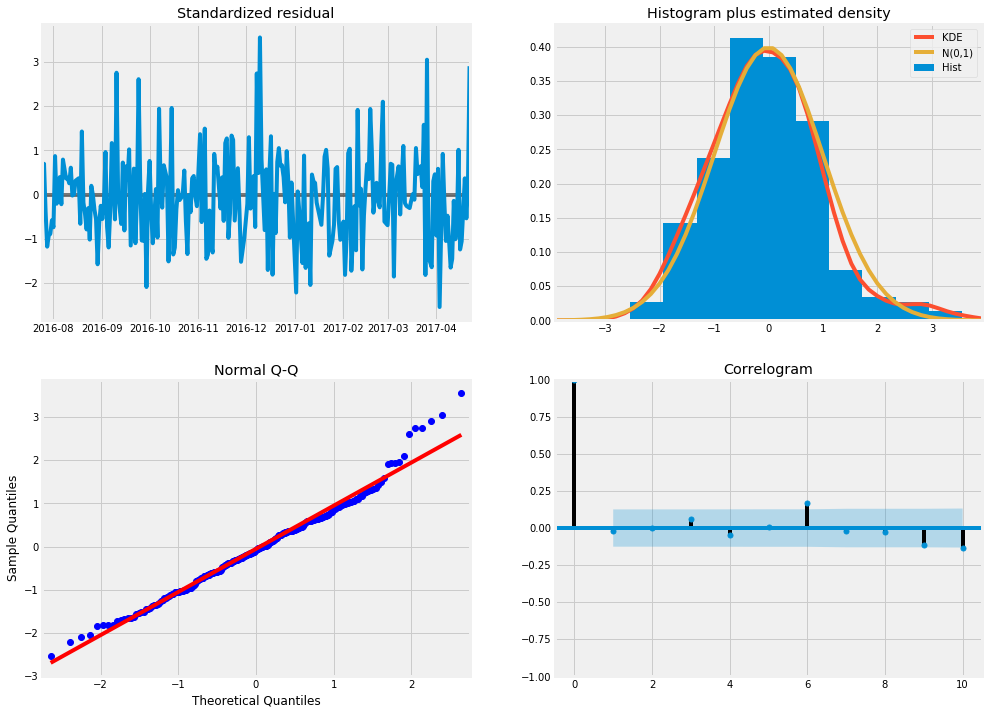

In [326]:
metric_choice=metric_choices['aic']
param, param_seasonal=sorted(mods[1], key=lambda x: x[metric_choice])[0][0:2]

best_aic_mod = sm.tsa.statespace.SARIMAX(test['visitors'],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

best_aic_results = best_aic_mod.fit()

print("BEST AIC:")
print("======================")

print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, best_aic_results.aic))

print(best_aic_results.summary().tables[1])

fig = best_aic_results.plot_diagnostics(figsize=(15, 12))
# plt.show()

You can see above that the estimated density plot looks good—the KDE looks normal. Also notice the residuals look like white noise, which is also good. The Q-Q plot looks pretty ok, but I'm not totally convinced. The biggest concern is the Correlogram's peak at 6. I'm not sure how to understand this, but it seems problematic. 

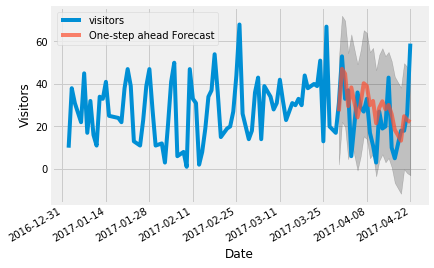

In [412]:
pred_best_aic = best_aic_results.get_prediction(start=pd.to_datetime('2017-03-30 00:00:00'), dynamic=False)
pred_ci_best_aic = pred_best_aic.conf_int()
ax = test['2017-01-01':].plot(label='observed')
_ = pred_best_aic.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

_ = ax.fill_between(pred_ci_best_aic.index,
                pred_ci_best_aic.iloc[:, 0],
                pred_ci_best_aic.iloc[:, 1], color='k', alpha=.2)

_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Visitors')
_ = plt.legend()

plt.show()

Not the most inspiring plot, looks not lovely.

BEST RMS:
ARIMA(3, 1, 1)x(2, 0, 3, 7) - rms:156.39688232897265
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.073      0.939      0.348      -0.074       0.210
ar.L2         -0.0888      0.066     -1.354      0.176      -0.217       0.040
ar.L3         -0.2484      0.068     -3.644      0.000      -0.382      -0.115
ma.L1         -0.9054      0.032    -28.395      0.000      -0.968      -0.843
ar.S.L7        0.1262      0.878      0.144      0.886      -1.594       1.846
ar.S.L14       0.0825      0.567      0.145      0.884      -1.029       1.194
ma.S.L7        0.0831      0.881      0.094      0.925      -1.643       1.809
ma.S.L14      -0.1685      0.543     -0.311      0.756      -1.232       0.895
ma.S.L21      -0.0179      0.169     -0.106      0.916      -0.350       0.314
sigma2       161.1152     13.357     12.062      0.000     134.936  

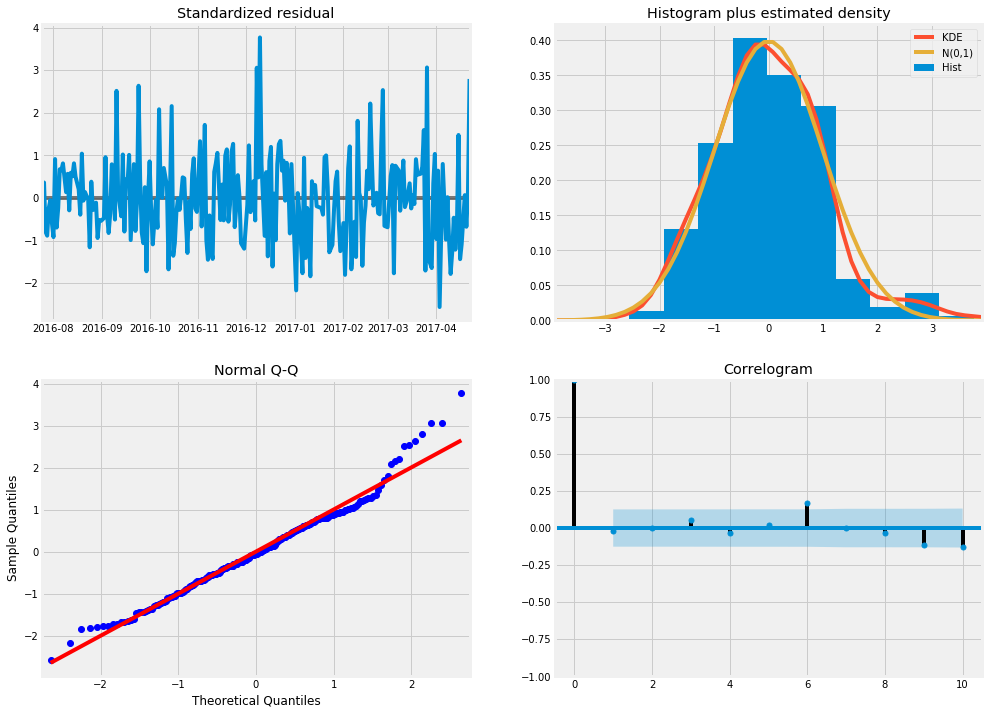

In [330]:
metric_choice=metric_choices['rms']
param, param_seasonal=sorted(mods[1], key=lambda x: x[metric_choice])[0][0:2]

best_rms_mod = sm.tsa.statespace.SARIMAX(test['visitors'],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

best_rms_results = best_rms_mod.fit()

print("BEST RMS:")
print("======================")


print('ARIMA{}x{} - rms:{}'.format(param, param_seasonal, rms(test['visitors'],best_rms_results.predict()) ))

print(best_rms_results.summary().tables[1])

fig = best_rms_results.plot_diagnostics(figsize=(15, 12))
# plt.show()

You can see above that the estimated density plot looks good—the KDE looks normal. Also notice the residuals look like white noise, which is also good. The Q-Q plot looks pretty ok, but I'm not totally convinced. The biggest concern is the Correlogram's peak at 6. I'm not sure how to understand this, but it seems problematic. 

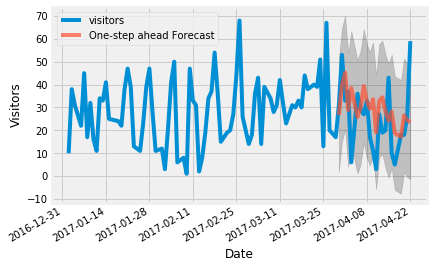

In [334]:
pred_best_rms = best_rms_results.get_prediction(start=pd.to_datetime('2017-03-30 00:00:00'), dynamic=False)
pred_ci_best_rms = pred_best_rms.conf_int()
ax = test['2017-01-01':].plot(label='observed')
_ = pred_best_rms.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci_best_rms.index,
                pred_ci_best_rms.iloc[:, 0],
                pred_ci_best_rms.iloc[:, 1], color='k', alpha=.2)

_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Visitors')
_ = plt.legend()

plt.show()

Not the most inspiring plot but I guess not totally awful.

BEST RMSLE:
ARIMA(3, 1, 1)x(2, 0, 3, 7) - rmsle:0.5778472618929067
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.073      0.939      0.348      -0.074       0.210
ar.L2         -0.0888      0.066     -1.354      0.176      -0.217       0.040
ar.L3         -0.2484      0.068     -3.644      0.000      -0.382      -0.115
ma.L1         -0.9054      0.032    -28.395      0.000      -0.968      -0.843
ar.S.L7        0.1262      0.878      0.144      0.886      -1.594       1.846
ar.S.L14       0.0825      0.567      0.145      0.884      -1.029       1.194
ma.S.L7        0.0831      0.881      0.094      0.925      -1.643       1.809
ma.S.L14      -0.1685      0.543     -0.311      0.756      -1.232       0.895
ma.S.L21      -0.0179      0.169     -0.106      0.916      -0.350       0.314
sigma2       161.1152     13.357     12.062      0.000     134.9

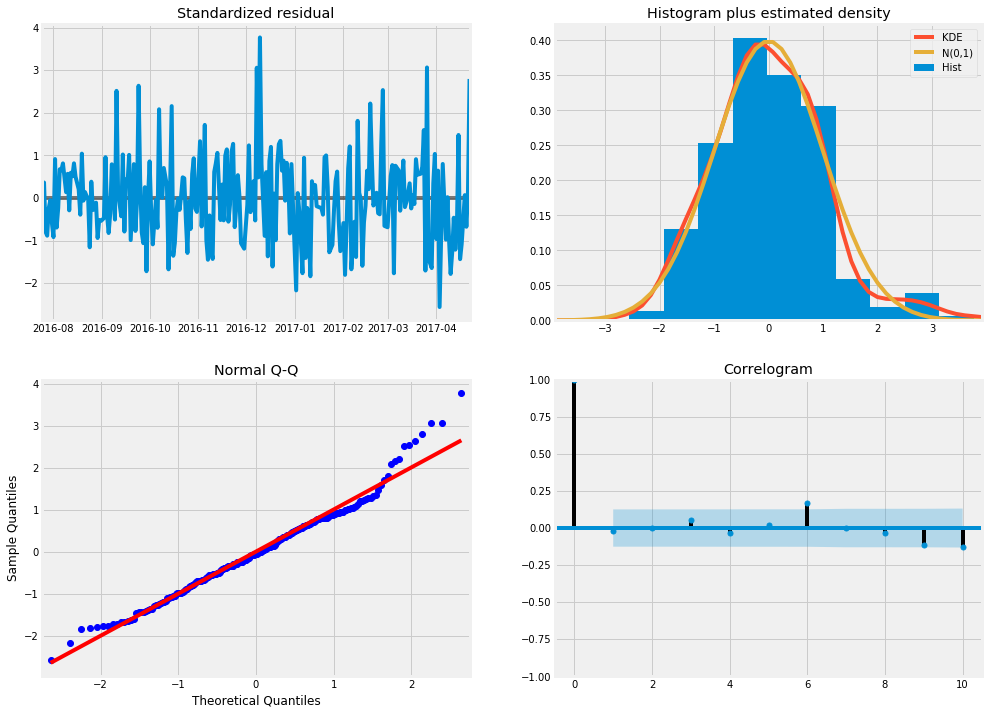

In [332]:
metric_choice=metric_choices['rmsle']
param, param_seasonal=sorted(mods[1], key=lambda x: x[metric_choice])[0][0:2]

best_rmsle_mod = sm.tsa.statespace.SARIMAX(test['visitors'],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

best_rmsle_results = best_rmsle_mod.fit()

print("BEST RMSLE:")
print("======================")


print('ARIMA{}x{} - rmsle:{}'.format(param, param_seasonal, rmsle(test['visitors'],best_rmsle_results.predict()) ))

print(best_rmsle_results.summary().tables[1])

fig = best_rmsle_results.plot_diagnostics(figsize=(15, 12))
# plt.show()

You can see above that the estimated density plot looks good—the KDE looks normal. Also notice the residuals look like white noise, which is also good. The Q-Q plot looks pretty ok, but I'm not totally convinced. The biggest concern is the Correlogram's peak at 6. I'm not sure how to understand this, but it seems problematic. 

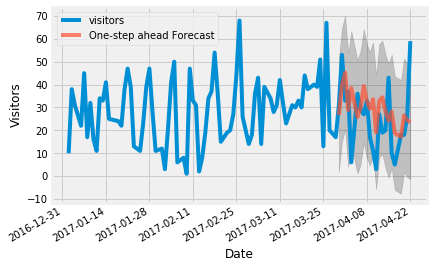

In [335]:
pred_best_rmsle = best_rmsle_results.get_prediction(start=pd.to_datetime('2017-03-30 00:00:00'), dynamic=False)
pred_ci_best_rmsle = pred_best_rmsle.conf_int()
ax = test['2017-01-01':].plot(label='observed')
_ = pred_best_rmsle.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci_best_rmsle.index,
                pred_ci_best_rmsle.iloc[:, 0],
                pred_ci_best_rmsle.iloc[:, 1], color='k', alpha=.2)

_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Visitors')
_ = plt.legend()

plt.show()

Not the most inspiring plot but I guess not totally awful.

## Model construction that builds 40-day windows

Because we have to predict a 40 day window, we should probably be ranking performance based on 40 days windows. This requires some different logic.

In [271]:
import datetime as dt
from IPython.display import display

This is very similar to build_model, but it's a bit more explicit in it's predictions. so it needs to know how long of predictions to make. Quiet makes this not spit out the performance for every single window. 

Here's a basic description of what is happening:
- computes the length of the series you put in
- uses the entire input series and the ord/sord params to build the model
- calls predict on that ending the prediction window at the last day of the series, and starting it `forecast_length` before
- prints the model, and three perf metrics
- returns a tupe that includes the predictions DF, and the three metrics

In [338]:
def build_40day_model(iter_param, series, params_list, static_param=None, forecast_length=40, quiet=False):
  if static_param==None:
    ords = iter_param
    sords = (1,0,0,0)
  else:
    ords = static_param
    sords = iter_param
  try:
      last = len(series)
      mod = sm.tsa.statespace.SARIMAX(
          series, trend='n', order=ords, seasonal_order=sords
        )
      res = mod.fit(disp=0)
      predictions_frame = res.predict(start = last-forecast_length, end= last-1, dynamic= True)
      if not quiet:
          print('ARIMA{}x{} - predictions:{} - AIC:{:03.5f} - RMS:{:03.5f} - RMSLE:{:03.5f}'.format(
                ords, 
                sords, 
                forecast_length,
                res.aic, 
                rms(series[-forecast_length:], predictions_frame), 
                rmsle(series[-forecast_length:],predictions_frame)
            )
          )  
      return (
            res.get_prediction(start = last-forecast_length, end= last-1, dynamic= True), 
            res.aic, 
            rms(series[-forecast_length:], predictions_frame), 
            rmsle(series[-forecast_length:],predictions_frame)
    )
  except:
    pass

This irritatingly complicated function takes prediction length and number of days back, to generate these pred windows from each date in the region you "care about". This is important for seeing model performance across time using those larger windows. Here's the idea:

- make sure your days back isn't too long
- iterate over a range of 1 to up to `num_days_back - pred_len` because those are all going to be "full windows"
- iterate over the rest of the range to reduce the length of the prediction because they're going to shrink as you come up against the last day of the actuals series
- for the output of both of the above loops:
 - add the three perf values from the series generated _on that day_ to their own columns
 - look at each day in the prediction, and put the prediciton in the row corresponding to that day, in the column corresponding to the number of days out

Now we have rows that correspond to single days, and columns that correspond to time series, which is what we actually want. This gives us the flexibility of having our performance metrics defined in "both directions"

In [459]:
test_models = []
test_ord_param, test_sord_param = (1,1,1), (1,1,1,7)
def build_historical_prediction_dataframe(ord_param, sord_param, model_list, dataframe, actuals_column, prediction_length=40, number_of_days_back=100):
    number_of_days_back = min(number_of_days_back, len(dataframe[actuals_column]))
    df_copy = dataframe.copy()
    for i in range(1, number_of_days_back-prediction_length):
        predictions_40, aic_40, rms_40, rmsle_40 = build_40day_model(sord_param, dataframe[actuals_column][:-i], model_list, ord_param, prediction_length, quiet=False)
        test_models.append(predictions_40.predicted_mean)
        df_copy.loc[predictions_40.predicted_mean.index[0], 'number_of_generated_predictions']=prediction_length
        df_copy.loc[predictions_40.predicted_mean.index[0], 'aic']=float("{0:.4f}".format(aic_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rms']=float("{0:.4f}".format(rms_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rmsle']=float("{0:.5f}".format(rmsle_40))
        for (idx, val) in [(idx,val) for idx, val in predictions_40.predicted_mean.iteritems()]:
            df_copy.loc[idx, (str(1+predictions_40.predicted_mean.index.get_loc(idx))+"_days_out_prediction")]=float("{0:.2f}".format(val))
    for j in range(40):
        predictions_40, aic_40, rms_40, rmsle_40 = build_40day_model(sord_param, dataframe[actuals_column], model_list, ord_param, prediction_length-j, quiet=False)
        test_models.append(predictions_40.predicted_mean)
        df_copy.loc[predictions_40.predicted_mean.index[0], 'number_of_generated_predictions']=prediction_length-j
        df_copy.loc[predictions_40.predicted_mean.index[0], 'aic']=float("{0:.4f}".format(aic_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rms']=float("{0:.4f}".format(rms_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rmsle']=float("{0:.5f}".format(rmsle_40))
        test_models.append(predictions_40.predicted_mean)
        for (idx, val) in [(idx,val) for idx, val in predictions_40.predicted_mean.iteritems()]:
            df_copy.loc[idx, (str(1+predictions_40.predicted_mean.index.get_loc(idx))+"_days_out_prediction")]=float("{0:.4f}".format(val))
    return df_copy
historical_prediction_output = build_historical_prediction_dataframe(test_ord_param, test_sord_param, test_models, test, 'visitors', 40, 100)
print("******Finished Predictions*******")

ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2073.23248 - RMS:174.87056 - RMSLE:0.61122
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2066.30175 - RMS:175.42296 - RMSLE:0.61211
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2058.90926 - RMS:195.86815 - RMSLE:0.63994
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2051.98796 - RMS:191.38682 - RMSLE:0.63146
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2043.16288 - RMS:179.79236 - RMSLE:0.57535
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2034.22045 - RMS:168.20190 - RMSLE:0.55186
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2027.01014 - RMS:173.83449 - RMSLE:0.56423
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2019.58901 - RMS:172.53743 - RMSLE:0.56380
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2011.97198 - RMS:178.73358 - RMSLE:0.55543
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:2005.04315 - RMS:180.44278 - RMSLE:0.55203
ARIMA(1, 1, 1)x(1, 1, 1, 7) - predictions:40 - AIC:1996.1814

All of the above has been built into the dataframe `historical_prediction_output` which we see is lower triangular if we look at the `X` most recent entries where `X` is the number_of_days_back. We also notice it has columns for `n_days_out_prediction` for each `n<=prediction_length`:

In [460]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
    historical_prediction_output[-100:]

air_store_id  visit_date  visitors  \
visit_date                                               
2016-12-28  air_0f0cdeee6c9bf3d7  2016-12-28        45   
2016-12-29  air_0f0cdeee6c9bf3d7  2016-12-29        33   
2016-12-30  air_0f0cdeee6c9bf3d7  2016-12-30        47   
2017-01-02  air_0f0cdeee6c9bf3d7  2017-01-02        10   
2017-01-03  air_0f0cdeee6c9bf3d7  2017-01-03        38   
2017-01-04  air_0f0cdeee6c9bf3d7  2017-01-04        31   
2017-01-06  air_0f0cdeee6c9bf3d7  2017-01-06        22   
2017-01-07  air_0f0cdeee6c9bf3d7  2017-01-07        45   
2017-01-08  air_0f0cdeee6c9bf3d7  2017-01-08        17   
2017-01-09  air_0f0cdeee6c9bf3d7  2017-01-09        32   
2017-01-10  air_0f0cdeee6c9bf3d7  2017-01-10        16   
2017-01-11  air_0f0cdeee6c9bf3d7  2017-01-11        11   
2017-01-12  air_0f0cdeee6c9bf3d7  2017-01-12        34   
2017-01-13  air_0f0cdeee6c9bf3d7  2017-01-13        33   
2017-01-14  air_0f0cdeee6c9bf3d7  2017-01-14        41   
2017-01-15  air_0f0cdeee6c9bf3d7  2017-01-15        25   
2017-01-18  air_0f0cdeee6c9bf3d7  2017-01-18        24   
2017-01-19  air_0f0cdeee6c9bf3d7  2017-01-19        22   
2017-01-20  air_0f0cdeee6c9bf3d7  2017-01-20        38   
2017-01-21  air_0f0cdeee6c9bf3d7  2017-01-21        47   
2017-01-22  air_0f0cdeee6c9bf3d7  2017-01-22        39   
2017-01-23  air_0f0cdeee6c9bf3d7  2017-01-23        13   
2017-01-25  air_0f0cdeee6c9bf3d7  2017-01-25        11   
2017-01-26  air_0f0cdeee6c9bf3d7  2017-01-26        23   
2017-01-27  air_0f0cdeee6c9bf3d7  2017-01-27        39   
2017-01-28  air_0f0cdeee6c9bf3d7  2017-01-28        47   
2017-01-29  air_0f0cdeee6c9bf3d7  2017-01-29        28   
2017-01-30  air_0f0cdeee6c9bf3d7  2017-01-30        11   
2017-02-01  air_0f0cdeee6c9bf3d7  2017-02-01        12   
2017-02-02  air_0f0cdeee6c9bf3d7  2017-02-02         3   
2017-02-03  air_0f0cdeee6c9bf3d7  2017-02-03        21   
2017-02-04  air_0f0cdeee6c9bf3d7  2017-02-04        41   
2017-02-05  air_0f0cdeee6c9bf3d7  2017-02-05        50   
2017-02-06  air_0f0cdeee6c9bf3d7  2017-02-06         6   
2017-02-08  air_0f0cdeee6c9bf3d7  2017-02-08         8   
2017-02-09  air_0f0cdeee6c9bf3d7  2017-02-09         1   
2017-02-10  air_0f0cdeee6c9bf3d7  2017-02-10        47   
2017-02-11  air_0f0cdeee6c9bf3d7  2017-02-11        33   
2017-02-12  air_0f0cdeee6c9bf3d7  2017-02-12        31   
2017-02-13  air_0f0cdeee6c9bf3d7  2017-02-13         2   
2017-02-14  air_0f0cdeee6c9bf3d7  2017-02-14         8   
2017-02-15  air_0f0cdeee6c9bf3d7  2017-02-15        19   
2017-02-16  air_0f0cdeee6c9bf3d7  2017-02-16        34   
2017-02-17  air_0f0cdeee6c9bf3d7  2017-02-17        37   
2017-02-18  air_0f0cdeee6c9bf3d7  2017-02-18        54   
2017-02-19  air_0f0cdeee6c9bf3d7  2017-02-19        36   
2017-02-20  air_0f0cdeee6c9bf3d7  2017-02-20        15   
2017-02-22  air_0f0cdeee6c9bf3d7  2017-02-22        19   
2017-02-23  air_0f0cdeee6c9bf3d7  2017-02-23        20   
2017-02-24  air_0f0cdeee6c9bf3d7  2017-02-24        27   
2017-02-25  air_0f0cdeee6c9bf3d7  2017-02-25        44   
2017-02-26  air_0f0cdeee6c9bf3d7  2017-02-26        68   
2017-02-27  air_0f0cdeee6c9bf3d7  2017-02-27        26   
2017-03-01  air_0f0cdeee6c9bf3d7  2017-03-01        14   
2017-03-02  air_0f0cdeee6c9bf3d7  2017-03-02        18   
2017-03-03  air_0f0cdeee6c9bf3d7  2017-03-03        36   
2017-03-04  air_0f0cdeee6c9bf3d7  2017-03-04        43   
2017-03-05  air_0f0cdeee6c9bf3d7  2017-03-05        14   
2017-03-06  air_0f0cdeee6c9bf3d7  2017-03-06        39   
2017-03-08  air_0f0cdeee6c9bf3d7  2017-03-08        34   
2017-03-09  air_0f0cdeee6c9bf3d7  2017-03-09        28   
2017-03-10  air_0f0cdeee6c9bf3d7  2017-03-10        31   
2017-03-11  air_0f0cdeee6c9bf3d7  2017-03-11        42   
2017-03-12  air_0f0cdeee6c9bf3d7  2017-03-12        32   
2017-03-13  air_0f0cdeee6c9bf3d7  2017-03-13        23   
2017-03-15  air_0f0cdeee6c9bf3d7  2017-03-15        31   
2017-03-16  air_0f0cdeee6c9bf3d7  2017-03-16        30   
2017-03-17  air_0f

Let's now build a simple way to apply a weighting metric across the RMSLE for pred_len windows to turn this into an overall performance value:

I use code from here: https://stackoverflow.com/questions/25649412/exponential-decay-on-python-pandas-dataframe

In [462]:
dataset = historical_prediction_output[['number_of_generated_predictions', 'aic', 'rms', 'rmsle']].dropna(axis=0, how='any')

print(dataset.describe())

weightspace = np.exp(np.linspace(len(dataset), 0, num=len(dataset))*-0.05)
def rollingsum(array):
    weights = weightspace[0-len(array):]
    # Convolve the array and the weights to obtain the result
    a = np.dot(array, weights).sum()
    return a

print(f"Means: \n{dataset.mean()} \nWeighted sum performance values: \n{pd.expanding_apply(dataset, rollingsum).iloc[-1]}")

       number_of_generated_predictions          aic         rms      rmsle
count                        99.000000    99.000000   99.000000  99.000000
mean                         32.121212  1937.954761  241.769520   0.726650
std                          12.119535   163.007653   91.377314   0.163167
min                           1.000000  1609.055300  146.618000   0.371160
25%                          25.500000  1795.637200  189.516350   0.618080
50%                          40.000000  2005.043100  235.286600   0.737930
75%                          40.000000  2086.229200  273.455450   0.876410
max                          40.000000  2086.229600  967.624200   0.948190
Means: 
number_of_generated_predictions      32.121212
aic                                1937.954761
rms                                 241.769520
rmsle                                 0.726650
dtype: float64 
Weighted sum performance values: 
number_of_generated_predictions      352.054392
aic                            

Here are the "vertical" performance visualizations; by this I mean, how the actuals compare to the predictions based on number of days out. You'll  notice that in these, the first day of the prediction is changing, which aligns with the first non-null date.

Prediction Start: 2016-12-29 00:00:00 — Prediction Column: 1_days_out_prediction — RMS: 198.34053324909084 — RMSLE: 0.6771267678748419


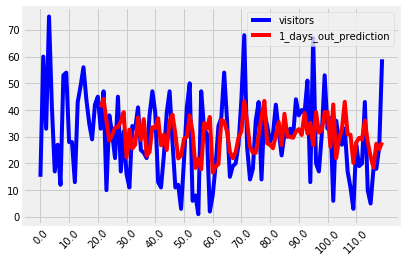

Prediction Start: 2016-12-30 00:00:00 — Prediction Column: 2_days_out_prediction — RMS: 203.75656049448978 — RMSLE: 0.6957463010986747


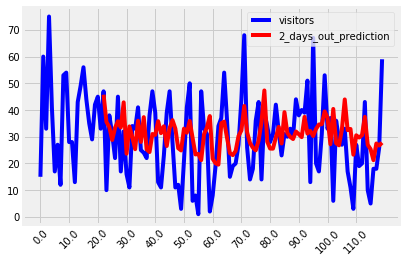

Prediction Start: 2017-01-02 00:00:00 — Prediction Column: 3_days_out_prediction — RMS: 206.23733626154637 — RMSLE: 0.7017491265874711


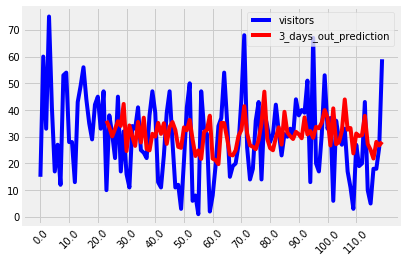

Prediction Start: 2017-01-03 00:00:00 — Prediction Column: 4_days_out_prediction — RMS: 199.63788803489584 — RMSLE: 0.692792783941762


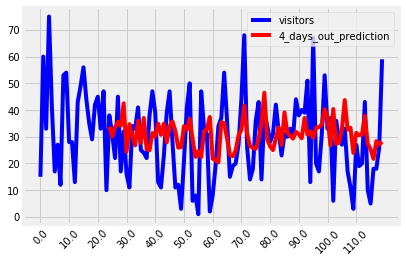

Prediction Start: 2017-01-04 00:00:00 — Prediction Column: 5_days_out_prediction — RMS: 201.03725871789476 — RMSLE: 0.6955268383591487


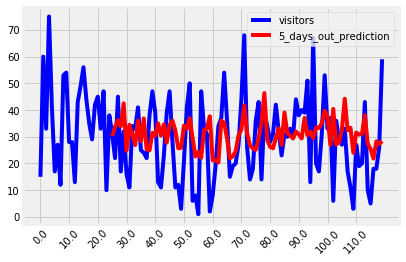

Prediction Start: 2017-01-06 00:00:00 — Prediction Column: 6_days_out_prediction — RMS: 203.88777539606386 — RMSLE: 0.7006023650145822


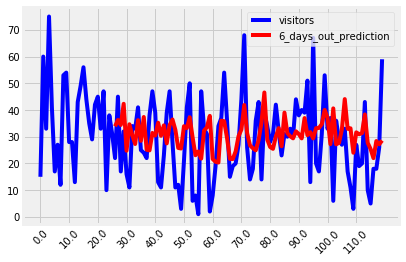

Prediction Start: 2017-01-07 00:00:00 — Prediction Column: 7_days_out_prediction — RMS: 207.05548410354845 — RMSLE: 0.7061531061602749


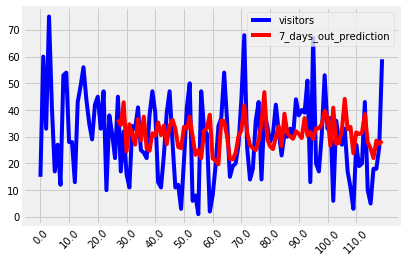

Prediction Start: 2017-01-08 00:00:00 — Prediction Column: 8_days_out_prediction — RMS: 233.1794910940217 — RMSLE: 0.7460063414210868


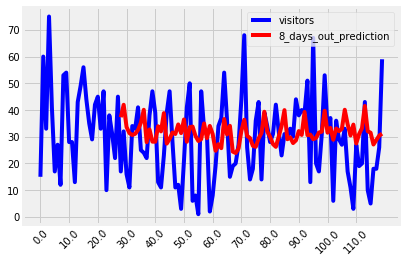

Prediction Start: 2017-01-09 00:00:00 — Prediction Column: 9_days_out_prediction — RMS: 235.14952782989008 — RMSLE: 0.7506482221027693


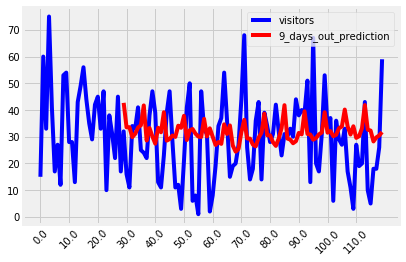

Prediction Start: 2017-01-10 00:00:00 — Prediction Column: 10_days_out_prediction — RMS: 234.64165706855556 — RMSLE: 0.7529341407075063


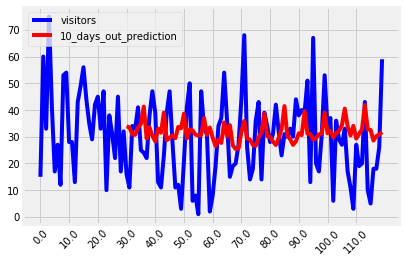

Prediction Start: 2017-01-11 00:00:00 — Prediction Column: 11_days_out_prediction — RMS: 232.47898925415726 — RMSLE: 0.7523914919560246


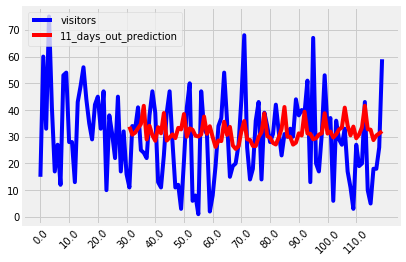

Prediction Start: 2017-01-12 00:00:00 — Prediction Column: 12_days_out_prediction — RMS: 229.17129786125 — RMSLE: 0.7484233587839253


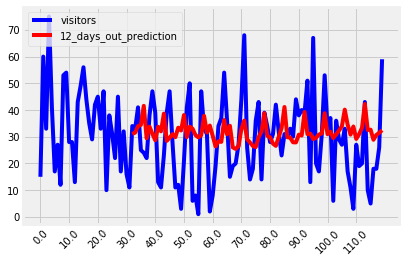

Prediction Start: 2017-01-13 00:00:00 — Prediction Column: 13_days_out_prediction — RMS: 233.52995500850577 — RMSLE: 0.7549515826473213


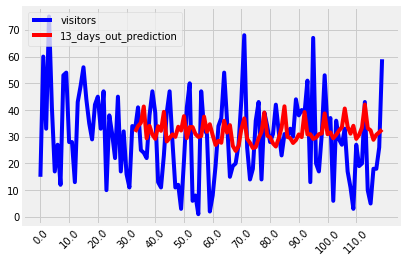

Prediction Start: 2017-01-14 00:00:00 — Prediction Column: 14_days_out_prediction — RMS: 238.59768400674417 — RMSLE: 0.7620270852262556


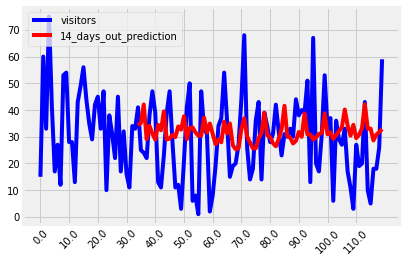

Prediction Start: 2017-01-15 00:00:00 — Prediction Column: 15_days_out_prediction — RMS: 244.7403166008235 — RMSLE: 0.7694121534170612


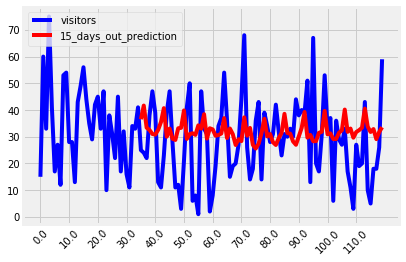

Prediction Start: 2017-01-18 00:00:00 — Prediction Column: 16_days_out_prediction — RMS: 243.55030598642855 — RMSLE: 0.770031734480833


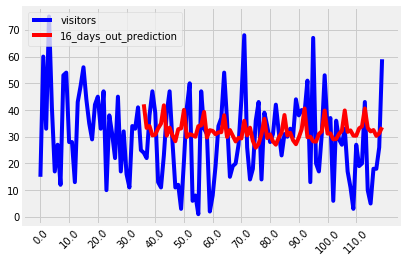

Prediction Start: 2017-01-19 00:00:00 — Prediction Column: 17_days_out_prediction — RMS: 239.58881444650598 — RMSLE: 0.7699157929885619


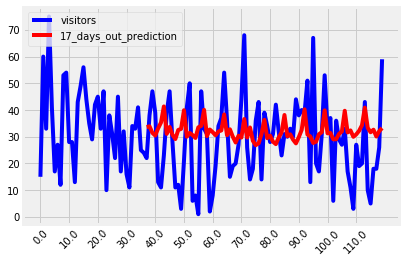

Prediction Start: 2017-01-20 00:00:00 — Prediction Column: 18_days_out_prediction — RMS: 239.84273206231708 — RMSLE: 0.7732148547364704


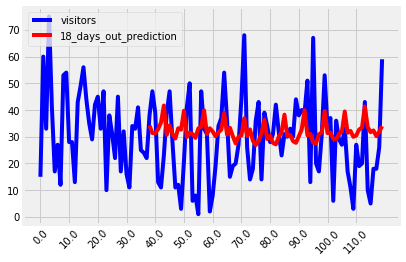

Prediction Start: 2017-01-21 00:00:00 — Prediction Column: 19_days_out_prediction — RMS: 244.6498072572839 — RMSLE: 0.7808037600499595


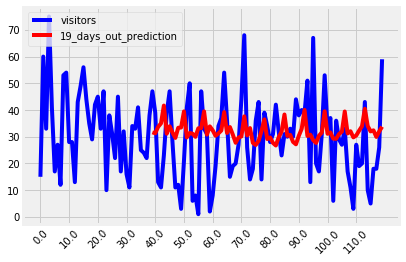

Prediction Start: 2017-01-22 00:00:00 — Prediction Column: 20_days_out_prediction — RMS: 248.248590693625 — RMSLE: 0.78742296876183


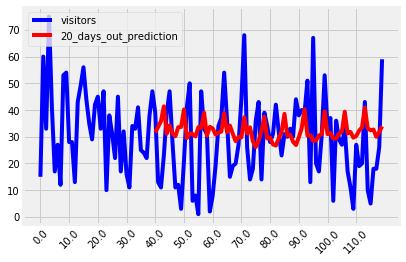

Prediction Start: 2017-01-23 00:00:00 — Prediction Column: 21_days_out_prediction — RMS: 253.08184331215188 — RMSLE: 0.7927824811425713


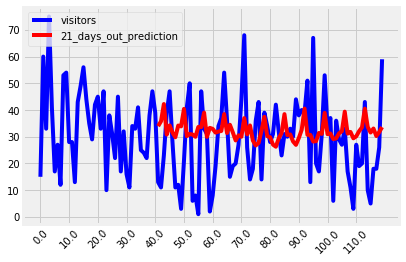

Prediction Start: 2017-01-25 00:00:00 — Prediction Column: 22_days_out_prediction — RMS: 243.12178532179482 — RMSLE: 0.7857655759708232


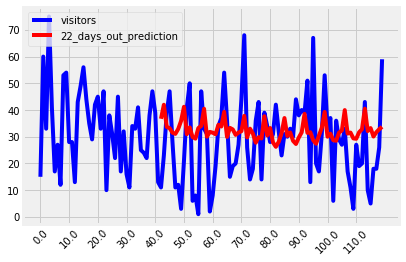

Prediction Start: 2017-01-26 00:00:00 — Prediction Column: 23_days_out_prediction — RMS: 234.04268306740266 — RMSLE: 0.7774867137344553


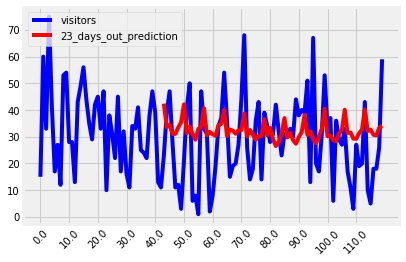

Prediction Start: 2017-01-27 00:00:00 — Prediction Column: 24_days_out_prediction — RMS: 230.02233196473682 — RMSLE: 0.7788432778057301


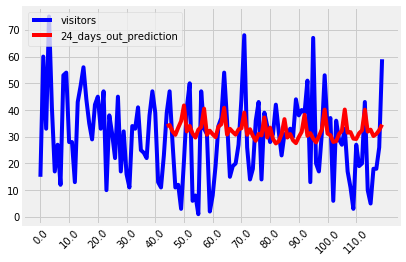

Prediction Start: 2017-01-28 00:00:00 — Prediction Column: 25_days_out_prediction — RMS: 235.83962329293328 — RMSLE: 0.7871022547554193


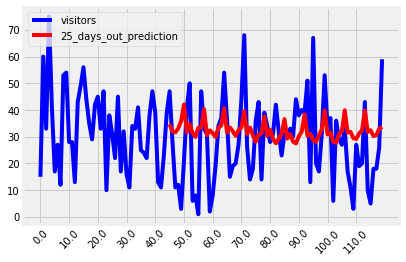

Prediction Start: 2017-01-29 00:00:00 — Prediction Column: 26_days_out_prediction — RMS: 239.43649317716216 — RMSLE: 0.7941769701500345


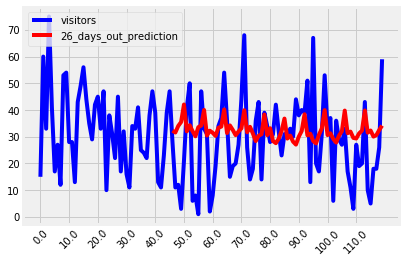

Prediction Start: 2017-01-30 00:00:00 — Prediction Column: 27_days_out_prediction — RMS: 244.1396527789041 — RMSLE: 0.8006349502248077


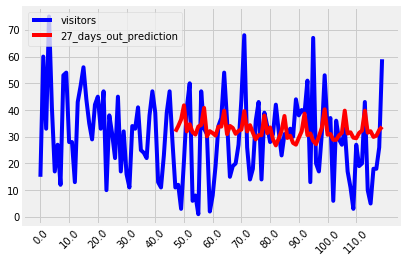

Prediction Start: 2017-02-01 00:00:00 — Prediction Column: 28_days_out_prediction — RMS: 242.27100928569448 — RMSLE: 0.797777680769384


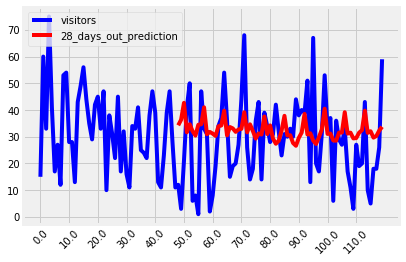

Prediction Start: 2017-02-02 00:00:00 — Prediction Column: 29_days_out_prediction — RMS: 237.34050216676056 — RMSLE: 0.7947831237542694


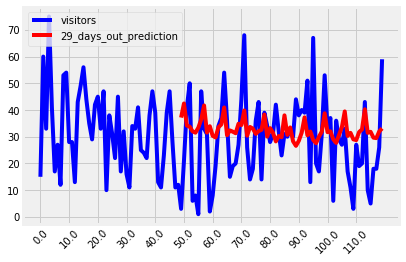

Prediction Start: 2017-02-03 00:00:00 — Prediction Column: 30_days_out_prediction — RMS: 222.8072563305714 — RMSLE: 0.7539035702235618


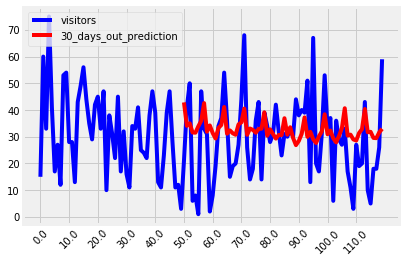

Prediction Start: 2017-02-04 00:00:00 — Prediction Column: 31_days_out_prediction — RMS: 219.91555402507245 — RMSLE: 0.7559837931817496


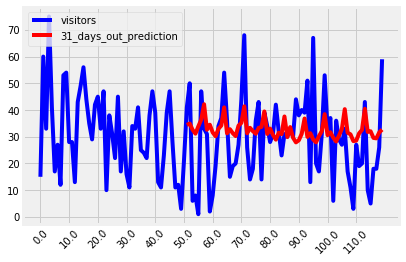

Prediction Start: 2017-02-05 00:00:00 — Prediction Column: 32_days_out_prediction — RMS: 226.36262182029412 — RMSLE: 0.7642245298059481


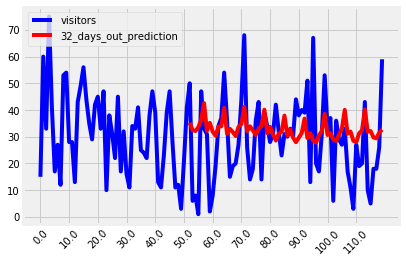

Prediction Start: 2017-02-06 00:00:00 — Prediction Column: 33_days_out_prediction — RMS: 228.9261134777612 — RMSLE: 0.7715682702303182


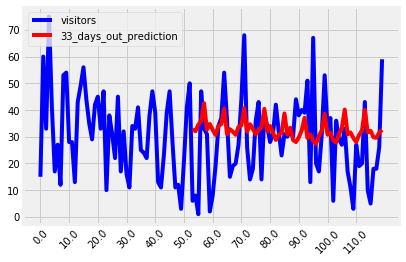

Prediction Start: 2017-02-08 00:00:00 — Prediction Column: 34_days_out_prediction — RMS: 221.00204858303027 — RMSLE: 0.7522481005041305


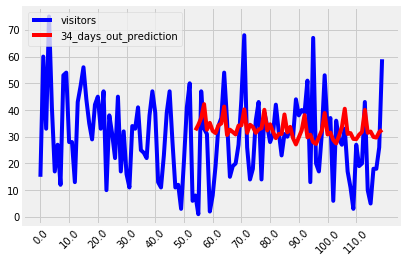

Prediction Start: 2017-02-09 00:00:00 — Prediction Column: 35_days_out_prediction — RMS: 214.25728121907693 — RMSLE: 0.7400249198614334


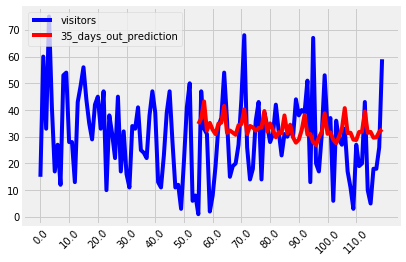

Prediction Start: 2017-02-10 00:00:00 — Prediction Column: 36_days_out_prediction — RMS: 197.99389568671876 — RMSLE: 0.6524346824420403


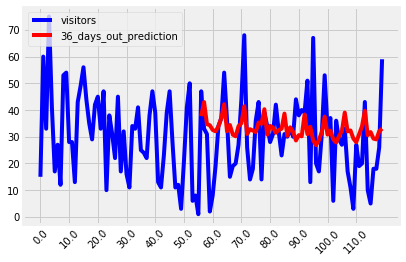

Prediction Start: 2017-02-11 00:00:00 — Prediction Column: 37_days_out_prediction — RMS: 198.59008635666663 — RMSLE: 0.6579331552429077


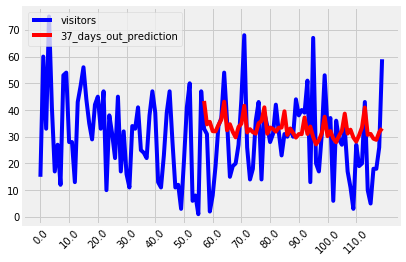

Prediction Start: 2017-02-12 00:00:00 — Prediction Column: 38_days_out_prediction — RMS: 203.8325435283871 — RMSLE: 0.6655963988896386


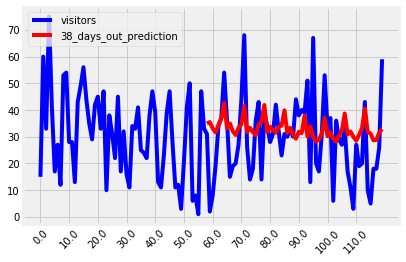

Prediction Start: 2017-02-13 00:00:00 — Prediction Column: 39_days_out_prediction — RMS: 208.58826928278688 — RMSLE: 0.6719015999887092


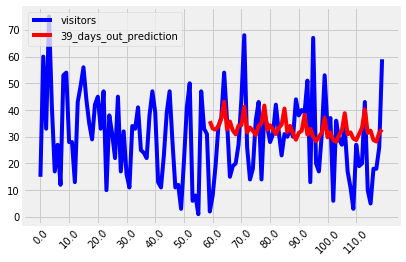

Prediction Start: 2017-02-14 00:00:00 — Prediction Column: 40_days_out_prediction — RMS: 194.62643214399998 — RMSLE: 0.5958505010735345


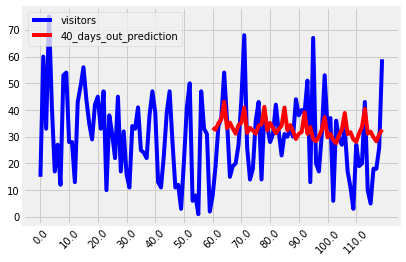

In [463]:
_ = historical_prediction_output.plot(label='Dynamic Forecast', ax=ax)

for i in range(40):
    col_name = str((i+1))+"_days_out_prediction"
    comp_df =historical_prediction_output[['visitors', col_name]].dropna(axis=0, how='any')
    print(f"Prediction Start: {comp_df.index[0]} — Prediction Column: {col_name} — RMS: {rms(comp_df['visitors'],comp_df[col_name])} — RMSLE: {rmsle(comp_df['visitors'],comp_df[col_name])}")
    _ = plt.tight_layout()
    _ = plt.plot(figsize=(20,4))
    _ = plt.plot(historical_prediction_output['visit_date'][-120:], historical_prediction_output['visitors'][-120:], 'b-', label='visitors')
    _ = plt.plot(historical_prediction_output['visit_date'][-120:], historical_prediction_output[col_name][-120:], 'r-', label=col_name)
    _ = ax = plt.axes()
    _ = ax.set_xticks(ax.get_xticks()[::10])
    _ = ax.set_xticklabels(ax.get_xticks(), rotation=45)
    _ = plt.legend(loc='best')
    _ = plt.show()

Here are the 'horizontal' plots for each day of the different predictions based on number of days out those predictions are made

Predictions for Date: 2016-12-29 00:00:00 — Number of predictions: 1


2016-12-29
count        1.00
mean        41.04
std           NaN
min         41.04
25%         41.04
50%         41.04
75%         41.04
max         41.04

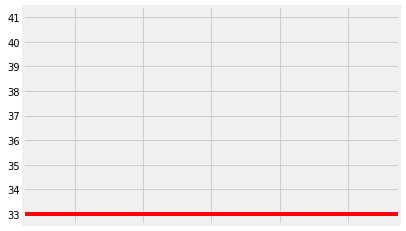

Predictions for Date: 2016-12-30 00:00:00 — Number of predictions: 2


2016-12-30
count    2.000000
mean    44.940000
std      1.117229
min     44.150000
25%     44.545000
50%     44.940000
75%     45.335000
max     45.730000

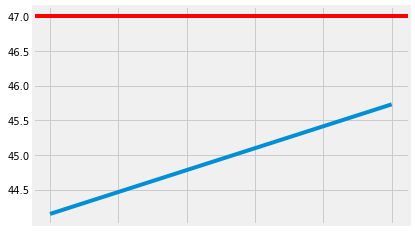

Predictions for Date: 2017-01-02 00:00:00 — Number of predictions: 3


2017-01-02
count    3.000000
mean    35.826667
std      0.248462
min     35.540000
25%     35.750000
50%     35.960000
75%     35.970000
max     35.980000

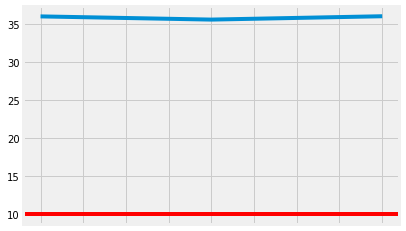

Predictions for Date: 2017-01-03 00:00:00 — Number of predictions: 4


2017-01-03
count    4.000000
mean    32.380000
std      2.541587
min     28.570000
25%     32.297500
50%     33.595000
75%     33.677500
max     33.760000

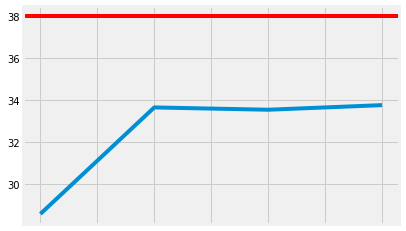

Predictions for Date: 2017-01-04 00:00:00 — Number of predictions: 5


2017-01-04
count    5.000000
mean    29.966000
std      0.699378
min     28.780000
25%     30.050000
50%     30.130000
75%     30.240000
max     30.630000

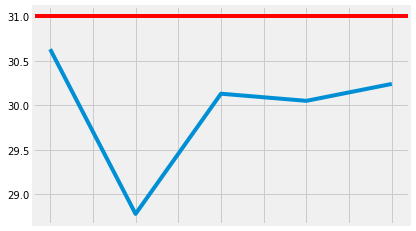

Predictions for Date: 2017-01-06 00:00:00 — Number of predictions: 6


2017-01-06
count    6.000000
mean    33.473333
std      0.344596
min     32.900000
25%     33.357500
50%     33.500000
75%     33.680000
max     33.890000

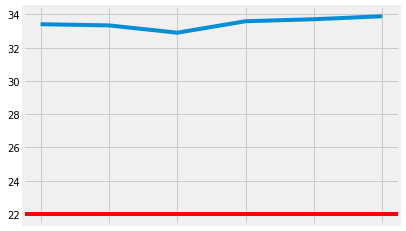

Predictions for Date: 2017-01-07 00:00:00 — Number of predictions: 7


2017-01-07
count    7.000000
mean    35.665714
std      0.938667
min     33.660000
25%     35.670000
50%     35.780000
75%     36.210000
max     36.460000

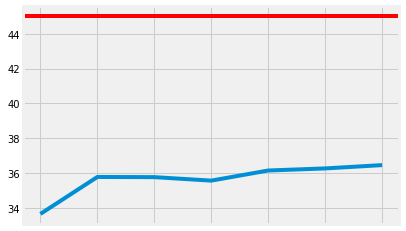

Predictions for Date: 2017-01-08 00:00:00 — Number of predictions: 8


2017-01-08
count    8.000000
mean    34.646250
std      1.251855
min     33.470000
25%     34.005000
50%     34.205000
75%     34.727500
max     37.300000

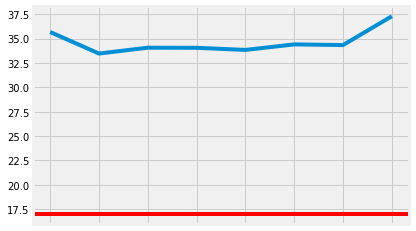

Predictions for Date: 2017-01-09 00:00:00 — Number of predictions: 9


2017-01-09
count    9.000000
mean    42.128889
std      1.137568
min     39.200000
25%     42.270000
50%     42.490000
75%     42.680000
max     42.890000

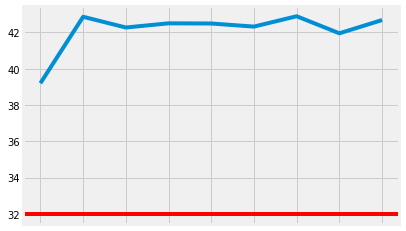

Predictions for Date: 2017-01-10 00:00:00 — Number of predictions: 10


2017-01-10
count   10.000000
mean    27.000000
std      4.674408
min     22.260000
25%     24.385000
50%     24.700000
75%     31.342500
max     33.860000

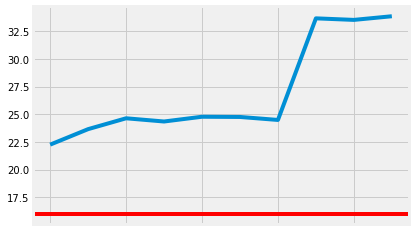

Predictions for Date: 2017-01-11 00:00:00 — Number of predictions: 11


2017-01-11
count   11.000000
mean    33.765455
std      1.020200
min     31.340000
25%     33.550000
50%     33.850000
75%     34.560000
max     34.710000

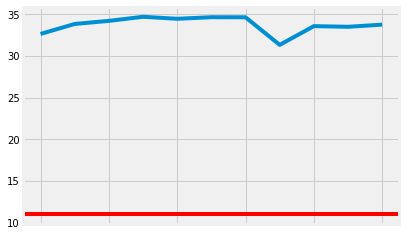

Predictions for Date: 2017-01-12 00:00:00 — Number of predictions: 12


2017-01-12
count     12.0000
mean      30.1050
std        1.4832
min       25.5500
25%       30.1200
50%       30.6050
75%       30.7825
max       31.0100

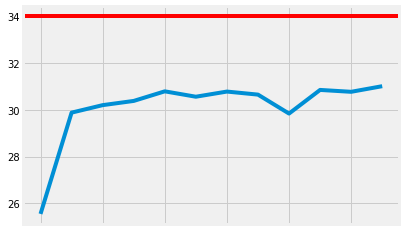

Predictions for Date: 2017-01-13 00:00:00 — Number of predictions: 13


2017-01-13
count   13.000000
mean    28.811538
std      2.441058
min     25.340000
25%     26.880000
50%     27.270000
75%     31.080000
max     31.800000

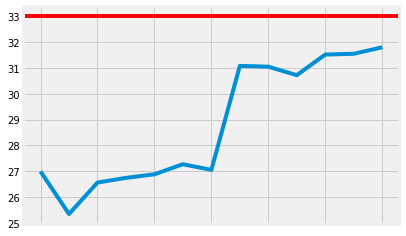

Predictions for Date: 2017-01-14 00:00:00 — Number of predictions: 14


2017-01-14
count   14.000000
mean    34.882143
std      1.489916
min     32.540000
25%     33.575000
50%     34.895000
75%     36.032500
max     37.220000

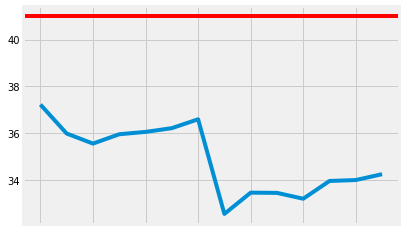

Predictions for Date: 2017-01-15 00:00:00 — Number of predictions: 15


2017-01-15
count   15.000000
mean    31.874000
std      3.559797
min     27.640000
25%     28.385000
50%     34.300000
75%     34.940000
max     36.550000

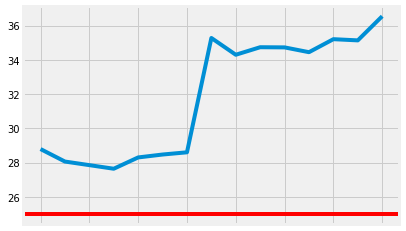

Predictions for Date: 2017-01-18 00:00:00 — Number of predictions: 16


2017-01-18
count   16.000000
mean    39.573750
std      2.291087
min     36.590000
25%     37.272500
50%     40.675000
75%     41.592500
max     42.140000

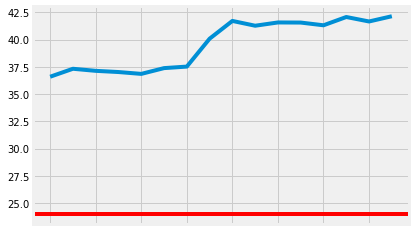

Predictions for Date: 2017-01-19 00:00:00 — Number of predictions: 17


2017-01-19
count   17.000000
mean    28.114706
std      3.223484
min     22.780000
25%     25.320000
50%     28.590000
75%     29.410000
max     33.610000

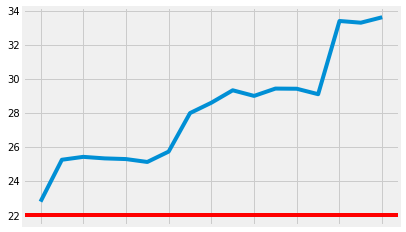

Predictions for Date: 2017-01-20 00:00:00 — Number of predictions: 18


2017-01-20
count   18.000000
mean    30.162778
std      4.506869
min     24.270000
25%     24.890000
50%     32.985000
75%     33.950000
max     34.170000

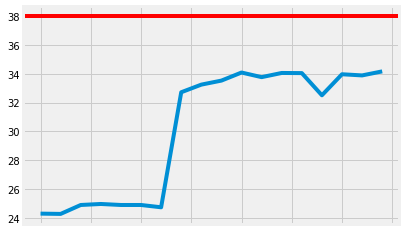

Predictions for Date: 2017-01-21 00:00:00 — Number of predictions: 19


2017-01-21
count   19.000000
mean    31.018947
std      0.997184
min     28.150000
25%     30.670000
50%     31.090000
75%     31.405000
max     33.580000

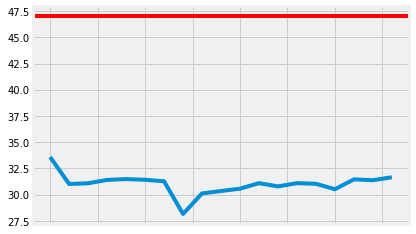

Predictions for Date: 2017-01-22 00:00:00 — Number of predictions: 20


2017-01-22
count    20.00000
mean     30.02650
std       1.40582
min      27.40000
25%      28.84500
50%      30.37500
75%      30.76500
max      33.23000

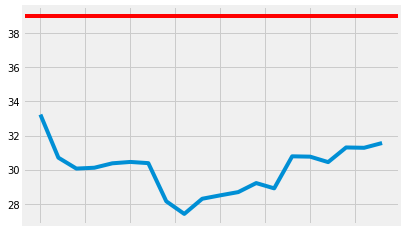

Predictions for Date: 2017-01-23 00:00:00 — Number of predictions: 21


2017-01-23
count   21.000000
mean    34.160000
std      1.112389
min     32.560000
25%     33.340000
50%     33.920000
75%     34.990000
max     36.910000

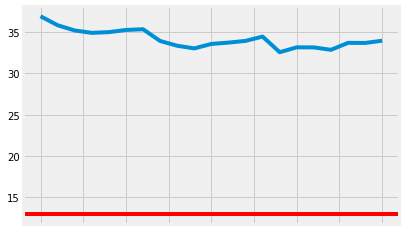

Predictions for Date: 2017-01-25 00:00:00 — Number of predictions: 22


2017-01-25
count   22.000000
mean    32.667273
std      2.500010
min     26.810000
25%     31.110000
50%     32.005000
75%     35.215000
max     36.720000

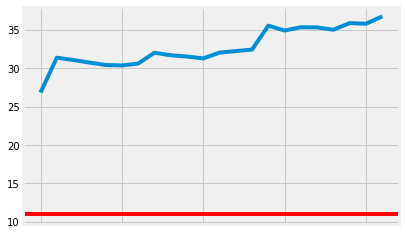

Predictions for Date: 2017-01-26 00:00:00 — Number of predictions: 23


2017-01-26
count   23.000000
mean    38.524783
std      3.383756
min     30.820000
25%     34.980000
50%     39.160000
75%     41.515000
max     42.380000

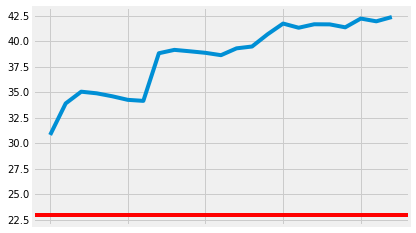

Predictions for Date: 2017-01-27 00:00:00 — Number of predictions: 24


2017-01-27
count   24.000000
mean    29.361667
std      2.317074
min     25.050000
25%     27.712500
50%     28.625000
75%     30.862500
max     33.930000

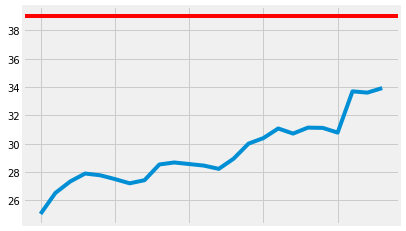

Predictions for Date: 2017-01-28 00:00:00 — Number of predictions: 25


2017-01-28
count   25.000000
mean    32.775200
std      2.204135
min     29.140000
25%     29.690000
50%     33.660000
75%     34.280000
max     35.910000

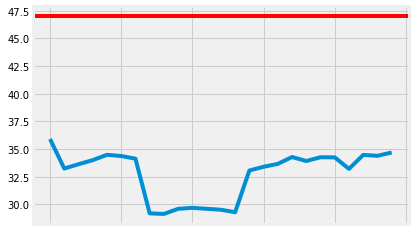

Predictions for Date: 2017-01-29 00:00:00 — Number of predictions: 26


2017-01-29
count   26.000000
mean    32.500385
std      2.501368
min     29.240000
25%     30.880000
50%     31.530000
75%     34.687500
max     38.300000

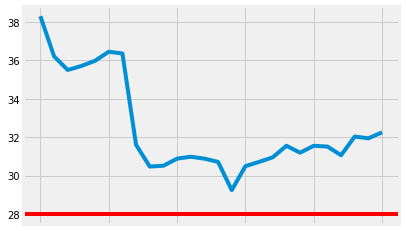

Predictions for Date: 2017-01-30 00:00:00 — Number of predictions: 27


2017-01-30
count   27.000000
mean    30.717778
std      1.361236
min     28.320000
25%     29.685000
50%     30.710000
75%     31.760000
max     33.070000

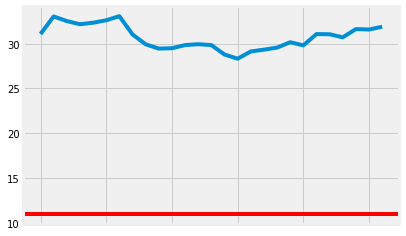

Predictions for Date: 2017-02-01 00:00:00 — Number of predictions: 28


2017-02-01
count   28.000000
mean    31.497500
std      3.720486
min     21.890000
25%     30.935000
50%     33.335000
75%     33.757500
max     34.600000

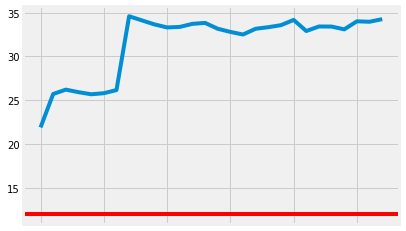

Predictions for Date: 2017-02-02 00:00:00 — Number of predictions: 29


2017-02-02
count   29.000000
mean    31.942414
std      4.118226
min     22.990000
25%     31.360000
50%     33.110000
75%     35.420000
max     37.170000

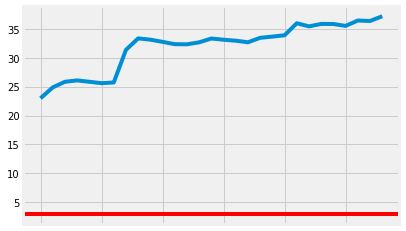

Predictions for Date: 2017-02-03 00:00:00 — Number of predictions: 30


2017-02-03
count   30.000000
mean    38.494000
std      3.548756
min     29.160000
25%     36.750000
50%     39.610000
75%     41.575000
max     42.850000

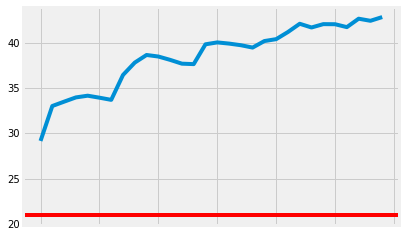

Predictions for Date: 2017-02-04 00:00:00 — Number of predictions: 31


2017-02-04
count   31.000000
mean    31.071290
std      1.737177
min     28.120000
25%     29.795000
50%     30.940000
75%     32.225000
max     34.430000

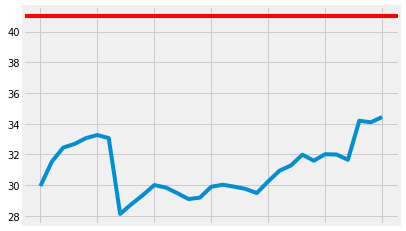

Predictions for Date: 2017-02-05 00:00:00 — Number of predictions: 32


2017-02-05
count   32.000000
mean    34.009687
std      2.054040
min     30.950000
25%     32.630000
50%     33.775000
75%     35.077500
max     38.030000

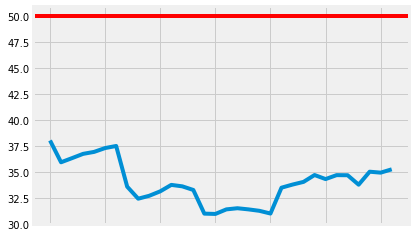

Predictions for Date: 2017-02-06 00:00:00 — Number of predictions: 33


2017-02-06
count   33.000000
mean    31.460303
std      1.301133
min     29.020000
25%     30.610000
50%     31.400000
75%     32.510000
max     33.800000

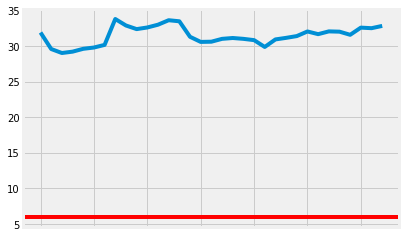

Predictions for Date: 2017-02-08 00:00:00 — Number of predictions: 34


2017-02-08
count   34.000000
mean    28.870882
std      3.586526
min     18.320000
25%     29.355000
50%     30.125000
75%     30.960000
max     32.390000

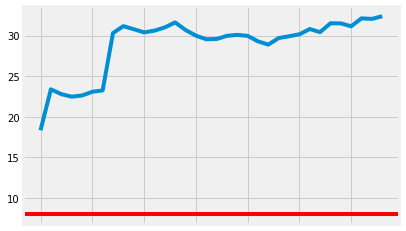

Predictions for Date: 2017-02-09 00:00:00 — Number of predictions: 35


2017-02-09
count   35.000000
mean    31.004571
std      3.888368
min     21.750000
25%     29.850000
50%     33.160000
75%     33.745000
max     34.760000

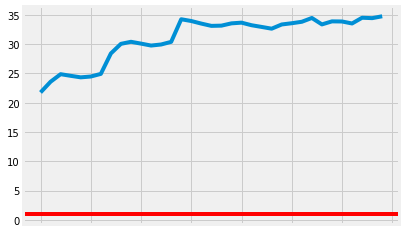

Predictions for Date: 2017-02-10 00:00:00 — Number of predictions: 36


2017-02-10
count   36.000000
mean    31.298611
std      5.467409
min     17.800000
25%     30.167500
50%     33.500000
75%     34.472500
max     37.710000

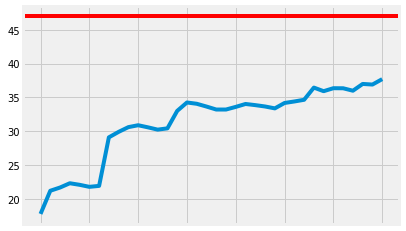

Predictions for Date: 2017-02-11 00:00:00 — Number of predictions: 37


2017-02-11
count   37.000000
mean    38.592703
std      3.651661
min     30.940000
25%     37.020000
50%     39.480000
75%     41.010000
max     43.390000

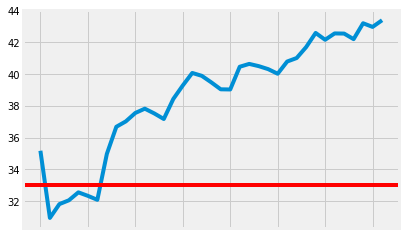

Predictions for Date: 2017-02-12 00:00:00 — Number of predictions: 38


2017-02-12
count   38.000000
mean    31.670000
std      1.513607
min     29.300000
25%     30.482500
50%     31.555000
75%     32.627500
max     34.980000

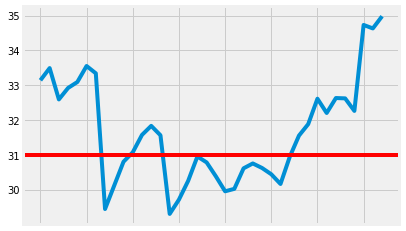

Predictions for Date: 2017-02-13 00:00:00 — Number of predictions: 39


2017-02-13
count   39.000000
mean    34.443846
std      1.910265
min     31.800000
25%     33.150000
50%     34.180000
75%     35.335000
max     38.250000

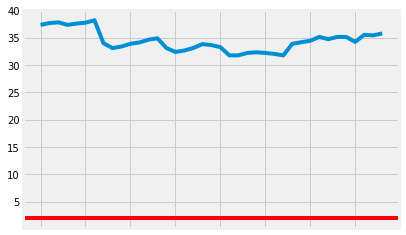

Predictions for Date: 2017-02-14 00:00:00 — Number of predictions: 40


2017-02-14
count   40.000000
mean    29.790750
std      4.295972
min     16.600000
25%     30.257500
50%     31.370000
75%     32.237500
max     33.410000

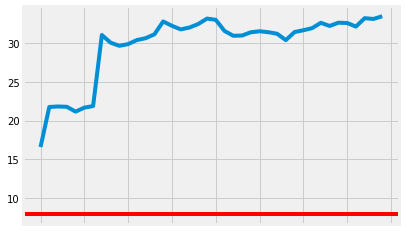

Predictions for Date: 2017-02-15 00:00:00 — Number of predictions: 40


2017-02-15
count   40.000000
mean    28.238500
std      4.007358
min     18.870000
25%     26.467500
50%     30.250000
75%     30.850000
max     32.670000

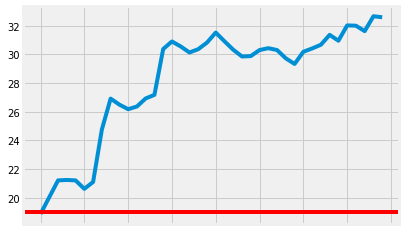

Predictions for Date: 2017-02-16 00:00:00 — Number of predictions: 40


2017-02-16
count   40.000000
mean    30.104000
std      5.175951
min     19.560000
25%     28.440000
50%     31.960000
75%     33.875000
max     35.050000

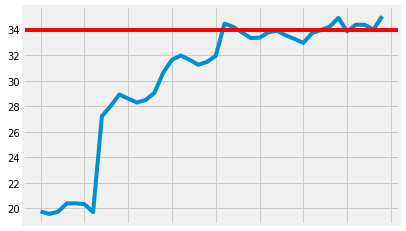

Predictions for Date: 2017-02-17 00:00:00 — Number of predictions: 40


2017-02-17
count   40.000000
mean    33.303500
std      3.080849
min     25.720000
25%     32.082500
50%     34.225000
75%     35.267500
max     36.980000

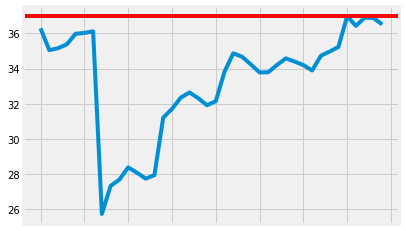

Predictions for Date: 2017-02-18 00:00:00 — Number of predictions: 40


2017-02-18
count    40.00000
mean     38.72850
std       2.67328
min      34.65000
25%      35.84250
50%      39.06500
75%      40.85250
max      43.10000

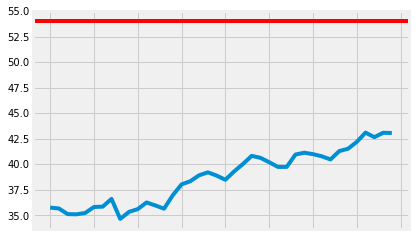

Predictions for Date: 2017-02-19 00:00:00 — Number of predictions: 40


2017-02-19
count   40.000000
mean    30.937000
std      0.979035
min     29.370000
25%     30.262500
50%     30.940000
75%     31.425000
max     33.190000

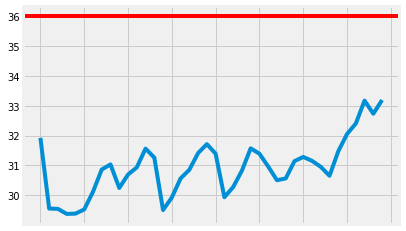

Predictions for Date: 2017-02-20 00:00:00 — Number of predictions: 40


2017-02-20
count    40.00000
mean     31.78900
std       4.26142
min      21.70000
25%      32.47250
50%      33.33000
75%      34.23000
max      35.71000

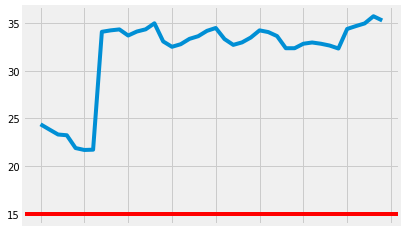

Predictions for Date: 2017-02-22 00:00:00 — Number of predictions: 40


2017-02-22
count   40.000000
mean    29.129750
std      3.843955
min     21.500000
25%     26.690000
50%     31.040000
75%     31.892500
max     33.290000

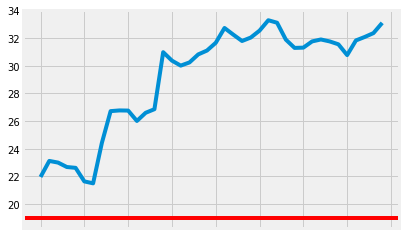

Predictions for Date: 2017-02-23 00:00:00 — Number of predictions: 40


2017-02-23
count   40.000000
mean    28.136500
std      2.770977
min     23.910000
25%     25.182500
50%     28.480000
75%     30.720000
max     31.830000

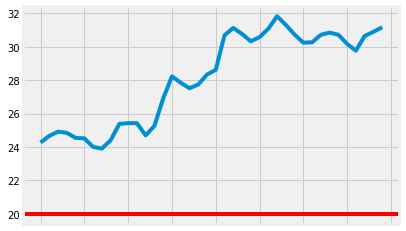

Predictions for Date: 2017-02-24 00:00:00 — Number of predictions: 40


2017-02-24
count   40.000000
mean    30.932250
std      2.888067
min     25.430000
25%     29.685000
50%     30.530000
75%     33.675000
max     34.870000

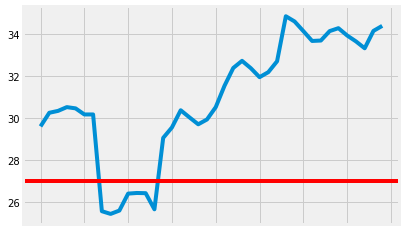

Predictions for Date: 2017-02-25 00:00:00 — Number of predictions: 40


2017-02-25
count   40.000000
mean    32.715750
std      1.781355
min     28.350000
25%     32.057500
50%     32.735000
75%     34.270000
max     35.390000

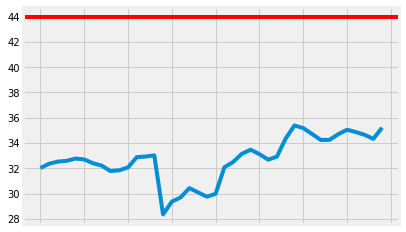

Predictions for Date: 2017-02-26 00:00:00 — Number of predictions: 40


2017-02-26
count   40.000000
mean    39.265250
std      2.205501
min     35.890000
25%     36.950000
50%     39.730000
75%     41.387500
max     43.330000

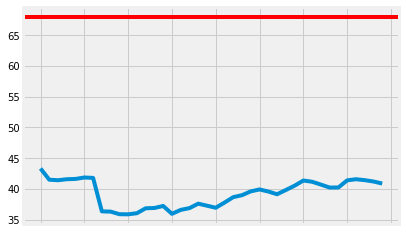

Predictions for Date: 2017-02-27 00:00:00 — Number of predictions: 40


2017-02-27
count   40.000000
mean    30.912500
std      1.125574
min     29.060000
25%     30.295000
50%     31.035000
75%     31.550000
max     35.420000

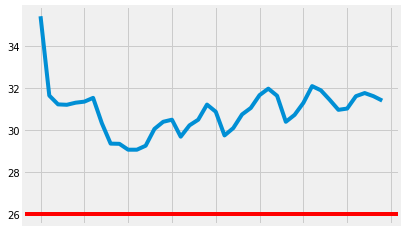

Predictions for Date: 2017-03-01 00:00:00 — Number of predictions: 40


2017-03-01
count   40.000000
mean    31.458500
std      2.933593
min     26.170000
25%     28.550000
50%     33.040000
75%     33.480000
max     34.680000

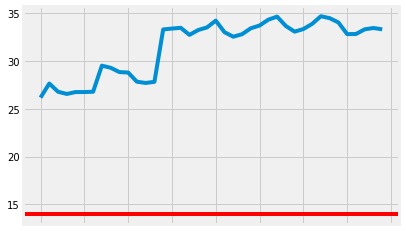

Predictions for Date: 2017-03-02 00:00:00 — Number of predictions: 40


2017-03-02
count   40.000000
mean    29.218250
std      2.891412
min     24.020000
25%     26.540000
50%     28.535000
75%     32.090000
max     33.670000

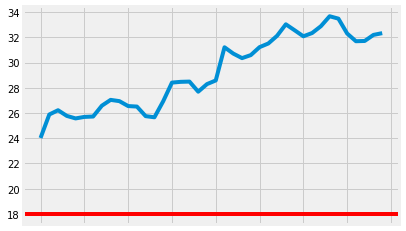

Predictions for Date: 2017-03-03 00:00:00 — Number of predictions: 40


2017-03-03
count   40.000000
mean    27.941500
std      2.464403
min     23.970000
25%     26.055000
50%     26.915000
75%     30.662500
max     32.250000

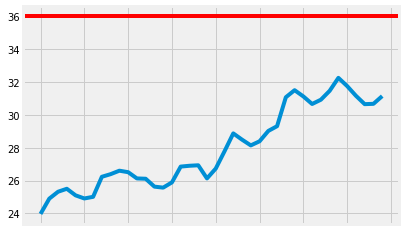

Predictions for Date: 2017-03-04 00:00:00 — Number of predictions: 40


2017-03-04
count   40.000000
mean    30.561500
std      2.255956
min     27.330000
25%     28.785000
50%     29.855000
75%     32.515000
max     35.320000

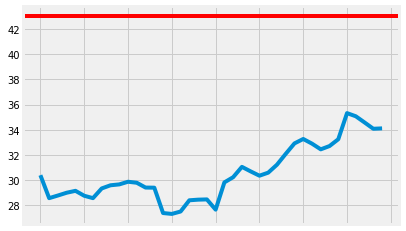

Predictions for Date: 2017-03-05 00:00:00 — Number of predictions: 40


2017-03-05
count   40.000000
mean    32.866000
std      1.962895
min     29.340000
25%     31.342500
50%     32.250000
75%     34.855000
max     37.440000

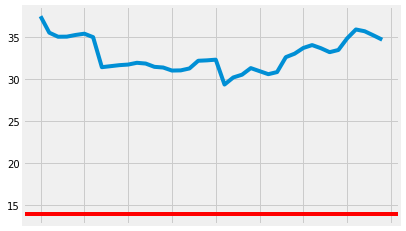

Predictions for Date: 2017-03-06 00:00:00 — Number of predictions: 40


2017-03-06
count   40.000000
mean    39.975500
std      3.296866
min     36.290000
25%     37.555000
50%     39.010000
75%     41.045000
max     47.320000

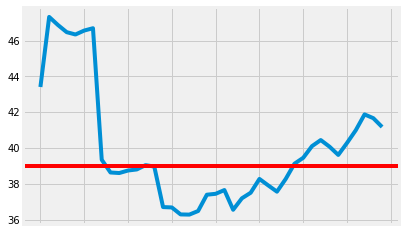

Predictions for Date: 2017-03-08 00:00:00 — Number of predictions: 40


2017-03-08
count   40.000000
mean    30.351500
std      1.179127
min     27.500000
25%     29.437500
50%     30.360000
75%     31.072500
max     32.580000

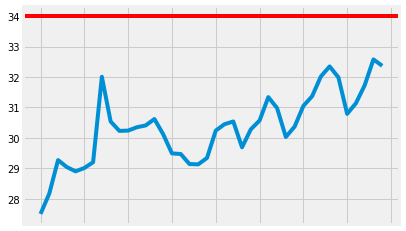

Predictions for Date: 2017-03-09 00:00:00 — Number of predictions: 40


2017-03-09
count   40.000000
mean    31.132280
std      2.886646
min     25.570000
25%     29.757500
50%     30.930000
75%     33.450000
max     35.140000

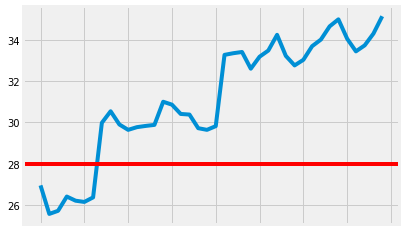

Predictions for Date: 2017-03-10 00:00:00 — Number of predictions: 40


2017-03-10
count   40.000000
mean    28.801890
std      2.497349
min     24.930000
25%     27.365000
50%     28.160000
75%     30.957500
max     33.420000

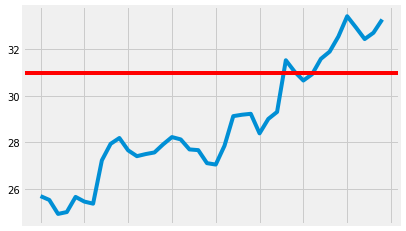

Predictions for Date: 2017-03-11 00:00:00 — Number of predictions: 40


2017-03-11
count   40.000000
mean    28.316887
std      1.765383
min     26.210000
25%     26.750000
50%     27.570000
75%     29.728825
max     31.910000

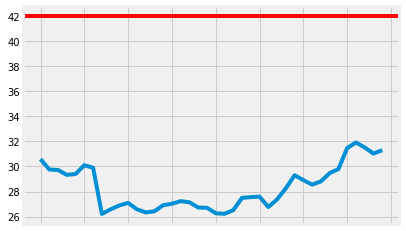

Predictions for Date: 2017-03-12 00:00:00 — Number of predictions: 40


2017-03-12
count   40.000000
mean    30.865630
std      1.970682
min     28.060000
25%     29.407500
50%     29.975000
75%     32.935000
max     35.499300

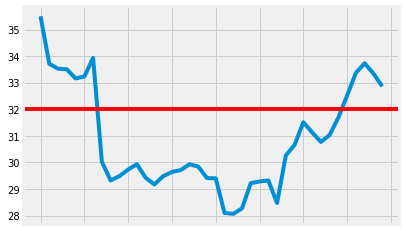

Predictions for Date: 2017-03-13 00:00:00 — Number of predictions: 40


2017-03-13
count   40.000000
mean    31.237830
std      2.288563
min     26.430000
25%     30.940000
50%     31.575000
75%     32.927500
max     34.480000

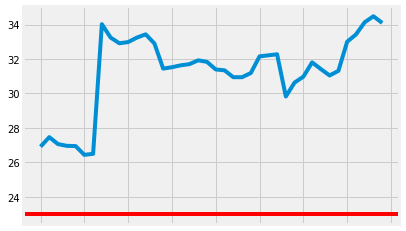

Predictions for Date: 2017-03-15 00:00:00 — Number of predictions: 40


2017-03-15
count   40.000000
mean    38.854408
std      1.470195
min     36.570000
25%     37.952500
50%     38.572900
75%     39.607500
max     41.810000

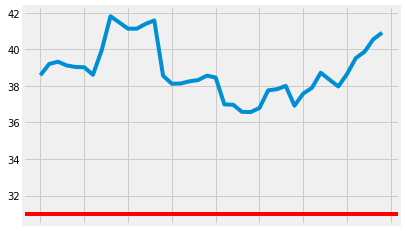

Predictions for Date: 2017-03-16 00:00:00 — Number of predictions: 40


2017-03-16
count   40.000000
mean    30.543440
std      0.793119
min     29.060000
25%     30.032500
50%     30.430000
75%     31.349650
max     32.410000

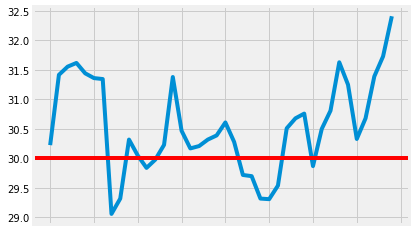

Predictions for Date: 2017-03-17 00:00:00 — Number of predictions: 40


2017-03-17
count   40.000000
mean    31.335245
std      1.629140
min     28.930000
25%     30.140500
50%     30.815000
75%     33.112500
max     34.500000

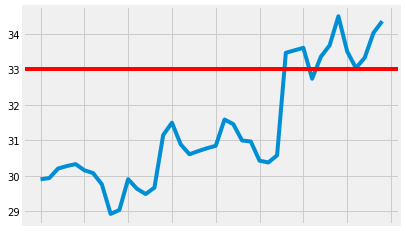

Predictions for Date: 2017-03-18 00:00:00 — Number of predictions: 40


2017-03-18
count   40.000000
mean    28.898103
std      1.245575
min     26.960000
25%     28.120000
50%     28.710000
75%     29.460000
max     31.950000

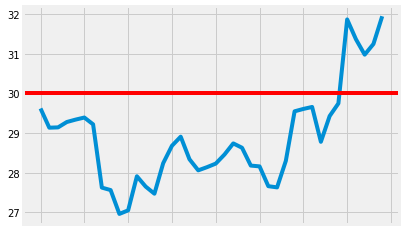

Predictions for Date: 2017-03-19 00:00:00 — Number of predictions: 40


2017-03-19
count   40.000000
mean    28.514555
std      1.769432
min     26.580000
25%     27.197500
50%     27.880000
75%     28.957500
max     32.078300

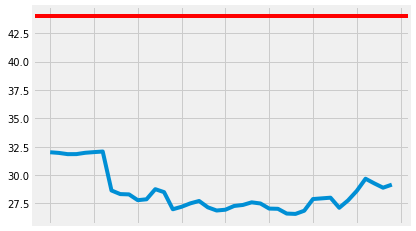

Predictions for Date: 2017-03-20 00:00:00 — Number of predictions: 40


2017-03-20
count   40.000000
mean    30.404365
std      0.994600
min     28.440000
25%     29.727500
50%     30.250000
75%     31.016500
max     32.827500

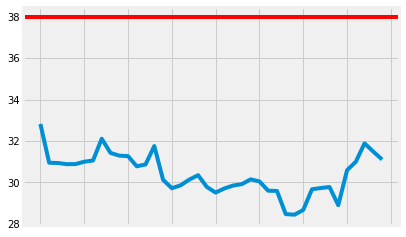

Predictions for Date: 2017-03-22 00:00:00 — Number of predictions: 40


2017-03-22
count   40.000000
mean    31.305032
std      1.166523
min     29.377000
25%     30.472825
50%     31.420000
75%     32.230000
max     33.340000

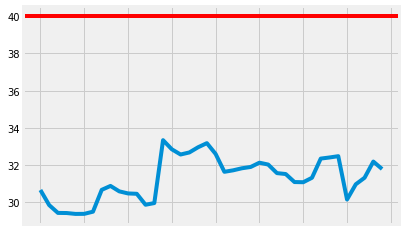

Predictions for Date: 2017-03-23 00:00:00 — Number of predictions: 40


2017-03-23
count   40.000000
mean    38.461295
std      1.133348
min     36.810000
25%     37.249650
50%     38.370000
75%     39.261875
max     40.570000

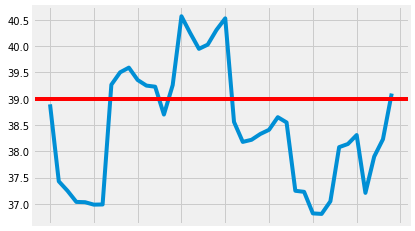

Predictions for Date: 2017-03-24 00:00:00 — Number of predictions: 40


2017-03-24
count   40.000000
mean    30.587792
std      0.487164
min     29.530000
25%     30.387500
50%     30.628200
75%     30.908400
max     31.450000

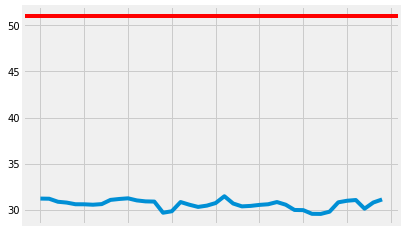

Predictions for Date: 2017-03-25 00:00:00 — Number of predictions: 40


2017-03-25
count   40.000000
mean    31.597857
std      1.126357
min     30.000000
25%     30.815025
50%     31.255000
75%     31.947500
max     35.249800

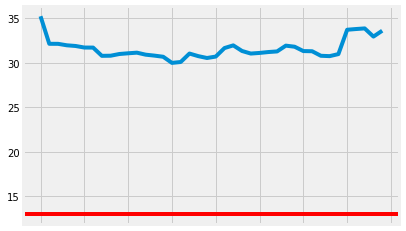

Predictions for Date: 2017-03-26 00:00:00 — Number of predictions: 40


2017-03-26
count   40.000000
mean    28.838148
std      0.686861
min     26.794900
25%     28.462500
50%     28.897100
75%     29.194300
max     30.274700

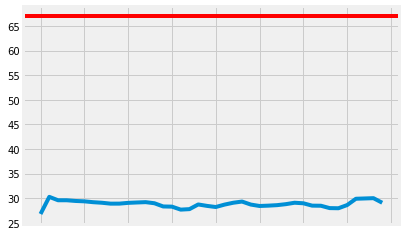

Predictions for Date: 2017-03-27 00:00:00 — Number of predictions: 40


2017-03-27
count   40.000000
mean    29.178830
std      2.599827
min     26.850000
25%     27.580000
50%     28.193250
75%     29.570475
max     39.215000

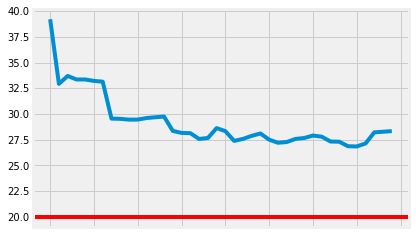

Predictions for Date: 2017-03-29 00:00:00 — Number of predictions: 40


2017-03-29
count   40.000000
mean    30.870682
std      1.315248
min     28.710000
25%     30.080000
50%     30.575000
75%     31.144200
max     34.574100

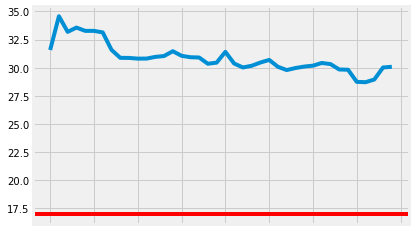

Predictions for Date: 2017-03-30 00:00:00 — Number of predictions: 40


2017-03-30
count   40.000000
mean    32.401367
std      1.210068
min     30.970000
25%     31.557550
50%     31.968950
75%     32.847500
max     35.342600

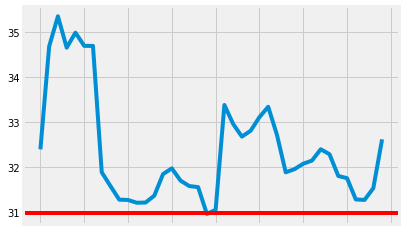

Predictions for Date: 2017-03-31 00:00:00 — Number of predictions: 40


2017-03-31
count   40.000000
mean    39.141328
std      0.919505
min     37.050000
25%     38.729775
50%     39.264350
75%     39.810850
max     40.490000

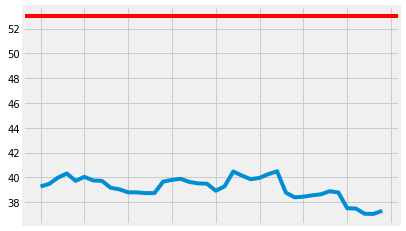

Predictions for Date: 2017-04-01 00:00:00 — Number of predictions: 40


2017-04-01
count   40.000000
mean    32.023142
std      2.650809
min     29.760000
25%     30.757500
50%     30.964550
75%     31.383425
max     39.256600

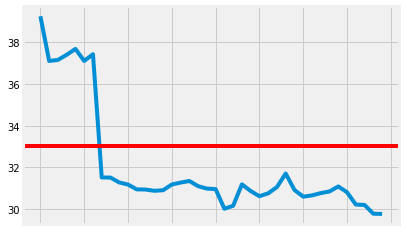

Predictions for Date: 2017-04-02 00:00:00 — Number of predictions: 40


2017-04-02
count   40.000000
mean    30.739013
std      1.895095
min     26.222800
25%     31.057500
50%     31.417900
75%     31.623175
max     33.301700

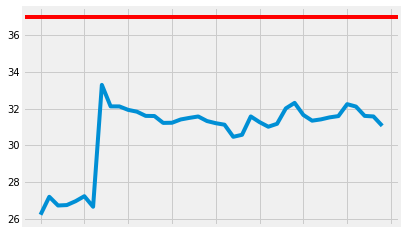

Predictions for Date: 2017-04-03 00:00:00 — Number of predictions: 40


2017-04-03
count   40.000000
mean    31.128545
std      4.519132
min     28.070000
25%     28.872500
50%     29.182400
75%     29.663325
max     42.081200

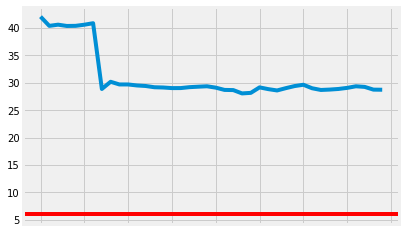

Predictions for Date: 2017-04-05 00:00:00 — Number of predictions: 40


2017-04-05
count   40.000000
mean    28.518252
std      1.721080
min     21.954500
25%     27.672500
50%     28.252750
75%     29.158350
max     33.074900

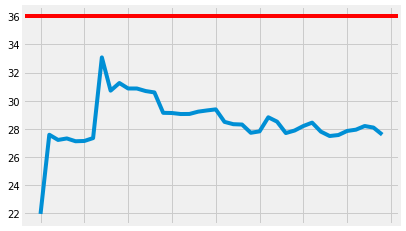

Predictions for Date: 2017-04-06 00:00:00 — Number of predictions: 40


2017-04-06
count   40.000000
mean    30.575120
std      1.477170
min     26.771800
25%     30.345000
50%     30.876500
75%     31.308175
max     33.210600

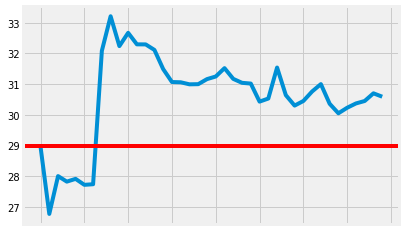

Predictions for Date: 2017-04-07 00:00:00 — Number of predictions: 40


2017-04-07
count   40.000000
mean    32.682465
std      0.686052
min     31.450000
25%     32.185900
50%     32.616250
75%     33.095000
max     34.302800

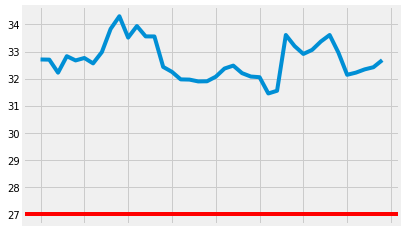

Predictions for Date: 2017-04-08 00:00:00 — Number of predictions: 40


2017-04-08
count   40.000000
mean    40.545452
std      1.658567
min     38.640000
25%     39.465950
50%     40.111150
75%     40.581550
max     44.238400

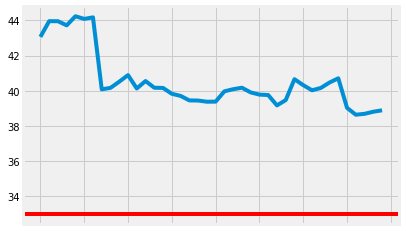

Predictions for Date: 2017-04-09 00:00:00 — Number of predictions: 40


2017-04-09
count   40.000000
mean    31.959602
std      1.197306
min     30.300000
25%     31.175325
50%     31.491800
75%     32.652400
max     34.667400

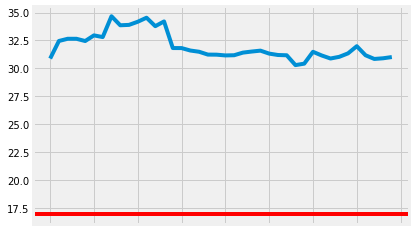

Predictions for Date: 2017-04-10 00:00:00 — Number of predictions: 40


2017-04-10
count   40.000000
mean    31.800732
std      0.878932
min     30.384400
25%     31.297100
50%     31.717950
75%     32.335950
max     33.657200

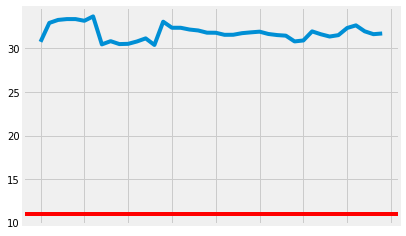

Predictions for Date: 2017-04-11 00:00:00 — Number of predictions: 40


2017-04-11
count   40.000000
mean    29.154948
std      3.323587
min     20.209000
25%     28.955000
50%     29.390800
75%     29.961375
max     34.542300

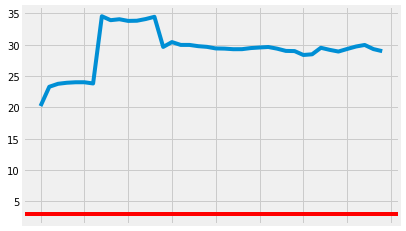

Predictions for Date: 2017-04-12 00:00:00 — Number of predictions: 40


2017-04-12
count   40.000000
mean    29.501318
std      1.181042
min     27.470100
25%     28.699300
50%     29.274900
75%     30.395350
max     31.763100

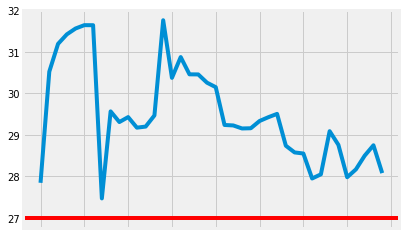

Predictions for Date: 2017-04-13 00:00:00 — Number of predictions: 40


2017-04-13
count   40.000000
mean    31.217617
std      0.753461
min     29.565400
25%     30.752500
50%     31.153850
75%     31.559925
max     33.122400

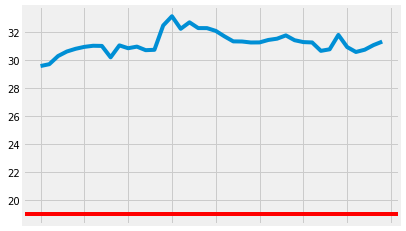

Predictions for Date: 2017-04-14 00:00:00 — Number of predictions: 40


2017-04-14
count   40.000000
mean    32.620555
std      1.110028
min     28.923300
25%     32.279650
50%     32.809450
75%     33.454175
max     34.297500

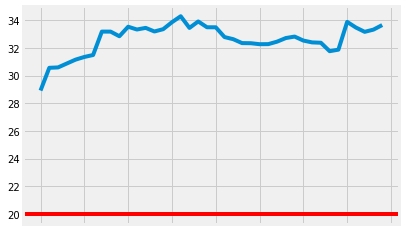

Predictions for Date: 2017-04-15 00:00:00 — Number of predictions: 40


2017-04-15
count   40.000000
mean    40.131533
std      1.362177
min     36.059500
25%     39.756750
50%     40.325950
75%     40.910625
max     42.241800

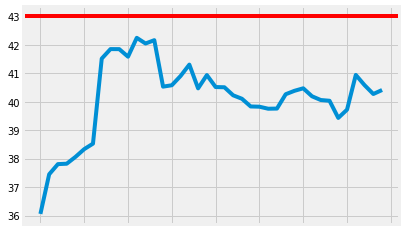

Predictions for Date: 2017-04-16 00:00:00 — Number of predictions: 40


2017-04-16
count   40.000000
mean    31.399363
std      1.984492
min     26.960400
25%     31.373175
50%     31.793950
75%     32.791100
max     33.988800

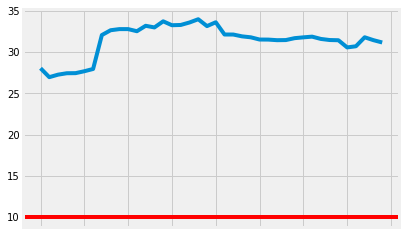

Predictions for Date: 2017-04-17 00:00:00 — Number of predictions: 40


2017-04-17
count   40.000000
mean    30.854512
std      2.817834
min     22.535300
25%     31.550175
50%     31.961400
75%     32.334425
max     33.232700

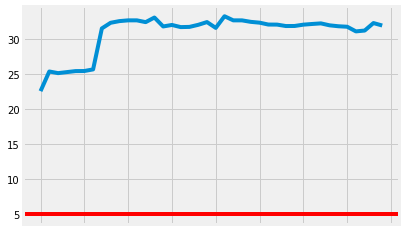

Predictions for Date: 2017-04-19 00:00:00 — Number of predictions: 40


2017-04-19
count   40.000000
mean    28.528638
std      3.677855
min     18.499500
25%     28.590350
50%     29.601000
75%     30.118575
max     33.066800

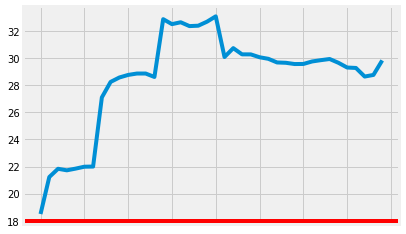

Predictions for Date: 2017-04-20 00:00:00 — Number of predictions: 40


2017-04-20
count   40.000000
mean    29.566660
std      1.025365
min     27.394000
25%     28.806600
50%     29.715650
75%     30.335900
max     31.688100

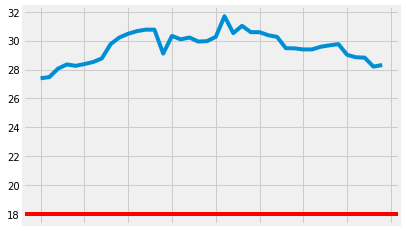

Predictions for Date: 2017-04-21 00:00:00 — Number of predictions: 40


2017-04-21
count   40.000000
mean    30.897987
std      2.024612
min     25.263100
25%     30.891200
50%     31.629950
75%     31.958200
max     33.360900

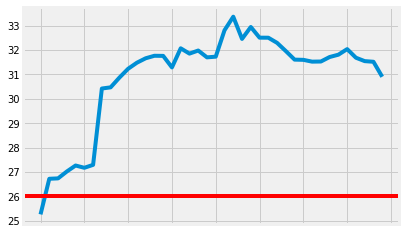

Predictions for Date: 2017-04-22 00:00:00 — Number of predictions: 40


2017-04-22
count   40.000000
mean    32.220652
std      2.010233
min     27.778600
25%     31.998725
50%     32.804050
75%     33.611225
max     34.557200

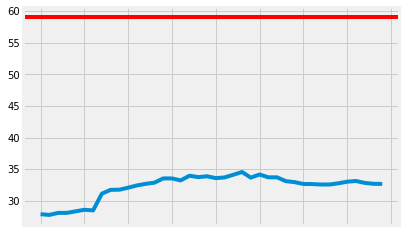

In [464]:
_ = historical_prediction_output.plot(label='Prediction Trends', ax=ax)
days_out_col_names = [f"{n}_days_out_prediction" for n in range(1,41)]

for i in historical_prediction_output[['visitors', '1_days_out_prediction']].dropna(axis=0, how='any').index:
    print(f"Predictions for Date: {i} — Number of predictions: {len(historical_prediction_output.loc[i, days_out_col_names].dropna(axis=0, how='any'))}")
#     display(pd.DataFrame(historical_prediction_output.loc[i, days_out_col_names].dropna(axis=0, how='any')))
    display(pd.DataFrame(pd.to_numeric(historical_prediction_output.loc[i, days_out_col_names].dropna(axis=0, how='any'))).describe(include = [np.number]))
    _ = historical_prediction_output.loc[i, days_out_col_names].plot.line()
    _ = plt.axhline(y=historical_prediction_output.loc[i, 'visitors'], color='r', linestyle='-')
    _ = plt.show()